# scorecardpipeline

## 引言

作为一名金融搬砖工作者，评分卡建模怎么也算是基操。本文主要对笔者日常使用的评分卡建模代码进行讲解，说明如何一步步从原始数据到最终评分卡模型以及如何解读产出的模型报告文档。

`scorecardpipeline` 封装了 `toad`、`scorecardpy`、`optbinning` 等评分卡建模相关组件，`API` 风格与 `sklearn` 高度一致，支持 `pipeline` 式端到端评分卡建模、模型报告输出、导出 `PMML` 文件、超参数搜索等功能，各位看官按需取用，用完记得顺带给个star以鼓励笔者继续开源相关工作。


| 微信                                                                                         | 微信公众号                                                                                        |
| ---------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------ |
| <img src="https://itlubber.art//upload/itlubber.png" alt="itlubber.png" width="50%" border=0/> | <img src="https://itlubber.art//upload/itlubber_art.png" alt="itlubber_art.png" width="50%" border=0/> |
| itlubber                                                                                       | itlubber_art                                                                                           |

## 项目说明

### 代码结构

`scorecardpipeline` 仓库下代码主要用于提供评分卡建模相关的组件，项目结构如下：

```base
>> tree
.
├── LICENSE                         # 开源协议
├── README.md                       # 相关说明文档
├── requirements.txt                # 相关依赖包
└── setup.py                        # 打包文件
├── examples                        # 演示样例
│   └── scorecard_samples.ipynb
└── scorecardpipeline               # scorecardpipeline 包文件
    ├── excel_writer.py             # 操作 excel 的公共方法
    ├── template.xlsx               # excel 模版文件
    ├── matplot_chinese.ttf         # 中文字体
    ├── processing.py               # 数据处理相关代码
    ├── model.py                    # 模型相关代码
    ├── logger.py                   # 日志打印方法
    └── utils.py                    # 公用方法
```

### 简要说明

+ `processing` 中提供了数据前处理相关的方法：特征筛选方法（`FeatureSelection`、`StepwiseSelection`）、变量分箱方法（`Combiner`）、变量证据权重转换方法（`WOETransformer`），方法继承`sklearn.base`中的`BaseEstimator`和`TransformerMixin`，能够支持构建`pipeline`和超参数搜索
+ `model`中提供了基于`sklearn.linear_model.LogisticRegression`实现的`ITLubberLogisticRegression`，同时重写了`toad.ScoreCard`，以支持模型相关内容的输出
+ `excel_writer` 中提供了操作 `excel` 的一系列公共方法，包含设置条件格式、设置列宽、设置数字格式、插入指定样式的内容（`insert_value2sheet`）、插入图片数据（`insert_pic2sheet`）、插入`dataframe`数据内容（`insert_df2sheet`）、保存`excel`文件（`save`）等方法


### `scorecardpipeline` 安装

In [ ]:
# !pip install scorecardpipeline -i https://pypi.Python.org/simple/

## 快速开始

1 本地调试模式 [通过 pip 安装可直接跳过]

In [ ]:
import sys
sys.path.append("../")

2 导入相关依赖文件

In [ ]:
import os
import numpy as np
import pandas as pd
import scorecardpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scorecardpipeline as sp

(CVXPY) May 24 02:27:18 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) May 24 02:27:18 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.6.2534). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


3 初始化环境

+ 去除python警告信息
+ 设置pandas显示列宽、浮点数显示精度
+ 设置matplotlib主题、中文字体支持
+ 固定随机种子[可选]
+ 日志打印[可选]

In [ ]:
logger = sp.init_setting(seed=10, logger=True)

4 数据集准备

4.1 数据集读取

In [ ]:
target = "creditability"
data = sp.germancredit()
data[target] = data[target].map({"good": 0, "bad": 1})

data.head()

,status_of_existing_checking_account,duration_in_month,credit_history,purpose,credit_amount,savings_account_and_bonds,present_employment_since,installment_rate_in_percentage_of_disposable_income,personal_status_and_sex,other_debtors_or_guarantors,...,property,age_in_years,other_installment_plans,housing,number_of_existing_credits_at_this_bank,job,number_of_people_being_liable_to_provide_maintenance_for,telephone,foreign_worker,creditability
0,... < 0 DM,6,critical account/ other credits existing (not at this bank),radio/television,1169,unknown/ no savings account,... >= 7 years,4,male : divorced/separated,none,...,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes,0
1,0 <= ... < 200 DM,48,existing credits paid back duly till now,radio/television,5951,... < 100 DM,1 <= ... < 4 years,2,male : divorced/separated,none,...,real estate,22,none,own,1,skilled employee / official,1,none,yes,1
2,no checking account,12,critical account/ other credits existing (not at this bank),education,2096,... < 100 DM,4 <= ... < 7 years,2,male : divorced/separated,none,...,real estate,49,none,own,1,unskilled - resident,2,none,yes,0
3,... < 0 DM,42,existing credits paid back duly till now,furniture/equipment,7882,... < 100 DM,4 <= ... < 7 years,2,male : divorced/separated,guarantor,...,building society savings agreement/ life insurance,45,none,for free,1,skilled employee / official,2,none,yes,0
4,... < 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : divorced/separated,none,...,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes,1


In [ ]:
train, test = train_test_split(data, test_size=0.3, shuffle=True, stratify=data[target])

logger.info(f"训练集数据: {train.shape}, 测试集数据: {test.shape}")

[ 2023-05-24 14:27:19,059 ][ INFO ][ 3133036894.py:<cell line: 3>:3 ] 训练集数据: (700, 21), 测试集数据: (300, 21)


4.2 数据集概要信息

In [ ]:
# 模拟实际场景中的数据， date 为数据集中的日期，为 datetime 类型，实际生产过程中可能是 申请时间｜放款时间｜入催时间｜流失时间 等

df = pd.DataFrame()
df["date"] = pd.date_range(start="2021-01-01", end="2021-06-30", freq="5H")
df[target] = np.random.randint(0, 2, len(df))

total_count = len(data)
dataset_summary = pd.DataFrame(
    [
        ["建模样本", "2022-01-01", "2023-01-31", len(data), len(data) / total_count, data[target].sum(), data[target].sum() / len(data), ""],
        ["训练集", "2022-01-01", "2023-12-31", len(train), len(train) / total_count, train[target].sum(), train[target].sum() / len(train), ""],
        ["测试集", "2022-01-01", "2023-12-31", len(test), len(test) / total_count, test[target].sum(), test[target].sum() / len(test), ""],
    ],
    columns=["数据集", "开始时间", "结束时间", "样本总数", "样本占比", "坏客户数", "坏客户占比", "备注"],
)

dataset_summary

,数据集,开始时间,结束时间,样本总数,样本占比,坏客户数,坏客户占比,备注
0,建模样本,2022-01-01,2023-01-31,1000,1.0000,300,0.3000,
1,训练集,2022-01-01,2023-12-31,700,0.7000,210,0.3000,
2,测试集,2022-01-01,2023-12-31,300,0.3000,90,0.3000,


In [ ]:
sp.distribution_plot?

Signature:
sp.distribution_plot(
    df,
    date='date',
    target='target',
    save=None,
    figsize=(10, 6),
    colors=['#2639E9', '#F76E6C', '#FE7715'],
    freq='M',
    anchor=0.94,
    result=False,
)
Docstring: <no docstring>
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/utils.py
Type:      function


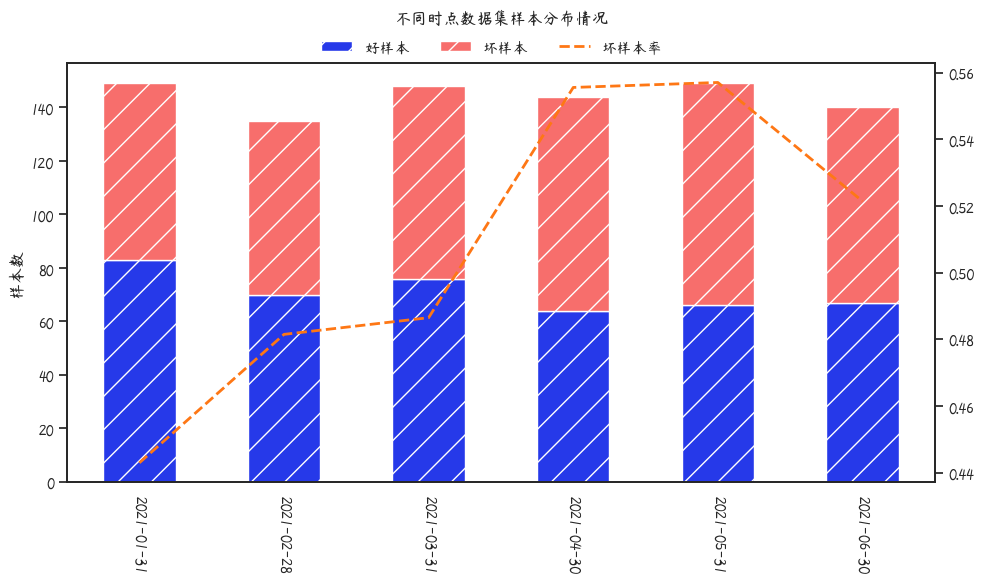

In [ ]:
sp.distribution_plot(df, date="date", target=target)

5 数据预处理

5.1 特征粗筛选[可选]

+ 根据特征重要性进行筛选

使用 `catboost` 在数据集上训练后的 `feature_importances_` 进行排序，选出 `top_k` 个较为重要的特征，如果需要排除高 `iv` 值的变量，可以通过 `max_iv` 先筛选特征后再通过 `catboost` 进行筛选

In [ ]:
sp.FeatureImportanceSelector?

Init signature:
sp.FeatureImportanceSelector(
    top_k=126,
    target='target',
    selector='catboost',
    params=None,
    max_iv=None,
)
Docstring:     
Base class for all estimators in scikit-learn.

Notes
-----
All estimators should specify all the parameters that can be set
at the class level in their ``__init__`` as explicit keyword
arguments (no ``*args`` or ``**kwargs``).
Init docstring:
基于特征重要性的特征筛选方法

Args:
    target: 数据集中标签名称，默认 target
    top_k: 依据特征重要性进行排序，筛选最重要的 top_k 个特征
    max_iv: 是否需要删除 IV 过高的特征，建议设置为 1.0
    selector: 特征选择器，目前只支持 catboost ，可以支持数据集中包含字符串的数据
    params: selector 的参数，不传使用默认参数
File:           ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/processing.py
Type:           type
Subclasses:     


+ 常规特征筛选方法

通过封装 `toad` 和 `scorecardpy` 库中相应方法进行实现，补全了 `toad` 缺少 `identical` （即唯一值占比）的筛选方法

In [ ]:
sp.FeatureSelection?

Init signature:
sp.FeatureSelection(
    target='target',
    empty=0.95,
    iv=0.02,
    corr=0.7,
    exclude=None,
    return_drop=True,
    identical=0.95,
    remove=None,
    engine='scorecardpy',
    target_rm=False,
)
Docstring:     
Mixin class for all transformers in scikit-learn.

If :term:`get_feature_names_out` is defined, then `BaseEstimator` will
automatically wrap `transform` and `fit_transform` to follow the `set_output`
API. See the :ref:`developer_api_set_output` for details.

:class:`base.OneToOneFeatureMixin` and
:class:`base.ClassNamePrefixFeaturesOutMixin` are helpful mixins for
defining :term:`get_feature_names_out`.
Init docstring:
ITLUBBER提供的特征筛选方法

Args:
    target: 数据集中标签名称，默认 target
    empty: 空值率，默认 0.95, 即空值占比超过 95% 的特征会被剔除
    iv: IV值，默认 0.02，即iv值小于 0.02 时特征会被剔除
    corr: 相关性，默认 0.7，即特征之间相关性大于 0.7 时会剔除iv较小的特征
    identical: 唯一值占比，默认 0.95，即当特征的某个值占比超过 95% 时，特征会被剔除
    engine: 特征筛选使用的引擎，可选 "toad", "scorecardpy" 两种，默认 scorecardpy
    remove: 引擎使用 scorecard

5.2 特征分箱

集成 `toad` 和 `optbinning` 的分箱方法，支持 `chi`、`dt`、`quantile`、`step`、`kmeans`、`cart`、`mdlp`、`uniform` 等分箱方法

In [ ]:
sp.Combiner?

Init signature:
sp.Combiner(
    target='target',
    method='chi',
    empty_separate=False,
    min_n_bins=2,
    max_n_bins=3,
    max_n_prebins=10,
    min_prebin_size=0.02,
    min_bin_size=0.05,
    max_bin_size=None,
    gamma=0.01,
    monotonic_trend='auto_asc_desc',
    rules={},
    n_jobs=1,
)
Docstring:     
Mixin class for all transformers in scikit-learn.

If :term:`get_feature_names_out` is defined, then `BaseEstimator` will
automatically wrap `transform` and `fit_transform` to follow the `set_output`
API. See the :ref:`developer_api_set_output` for details.

:class:`base.OneToOneFeatureMixin` and
:class:`base.ClassNamePrefixFeaturesOutMixin` are helpful mixins for
defining :term:`get_feature_names_out`.
Init docstring:
特征分箱封装方法

Args:
    target: 数据集中标签名称，默认 target
    method: 特征分箱方法，可选 "chi", "dt", "quantile", "step", "kmeans", "cart", "mdlp", "uniform", 参考 toad.Combiner & optbinning.OptimalBinning
    empty_separate: 是否空值单独一箱, 默认 False，推荐设置为 True
    min_n_bins: 最小分箱

5.3 `WOE` 编码

In [ ]:
sp.WOETransformer?

Init signature: sp.WOETransformer(target='target', exclude=None)
Docstring:     
Mixin class for all transformers in scikit-learn.

If :term:`get_feature_names_out` is defined, then `BaseEstimator` will
automatically wrap `transform` and `fit_transform` to follow the `set_output`
API. See the :ref:`developer_api_set_output` for details.

:class:`base.OneToOneFeatureMixin` and
:class:`base.ClassNamePrefixFeaturesOutMixin` are helpful mixins for
defining :term:`get_feature_names_out`.
Init docstring:
WOE转换器

Args:
    target: 数据集中标签名称，默认 target
    exclude: 不需要转换 woe 的列
File:           ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/processing.py
Type:           type
Subclasses:     


5.4 特征精筛[可选]

通常特征分箱转 `woe` 编码后，特征之间的相关性会增加，变量 `iv` 指标可能有一定的下降，为了避免多重共线性以及无效变量入模，会在 `woe` 编码后在筛选一次变量，筛选方法参考 `5.1` 中的 `sp.FeatureSelection` 使用方法，

5.5 逐步回归筛选[可选]

逐步回归是以线性回归为基础的方法。其思路是将特征一个接着一个引入，并在引入一个新特征后，对已入选回归模型的旧特征逐个进行检验，将认为没有意义的特征删除，直到没有新特征引入也没有旧特征删除，从而保证回归模型中每一个特征都有意义（即统计意义上的显著）。在正式进行逻辑回归建模之前，增加一步逐步回归剔除特征，能够在一定程度上减少特征之间的多重共线性，同时也能保证逻辑回归具有更好的效果。

In [ ]:
sp.StepwiseSelection?

Init signature:
sp.StepwiseSelection(
    target='target',
    estimator='ols',
    direction='both',
    criterion='aic',
    max_iter=None,
    return_drop=True,
    exclude=None,
    intercept=True,
    p_value_enter=0.2,
    p_remove=0.01,
    p_enter=0.01,
    target_rm=False,
)
Docstring:     
Mixin class for all transformers in scikit-learn.

If :term:`get_feature_names_out` is defined, then `BaseEstimator` will
automatically wrap `transform` and `fit_transform` to follow the `set_output`
API. See the :ref:`developer_api_set_output` for details.

:class:`base.OneToOneFeatureMixin` and
:class:`base.ClassNamePrefixFeaturesOutMixin` are helpful mixins for
defining :term:`get_feature_names_out`.
Init docstring:
逐步回归筛选方法

Args:
    target: 数据集中标签名称，默认 target
    estimator: 预估器，默认 ols，可选 "ols", "lr", "lasso", "ridge"，通常默认即可
    direction: 逐步回归方向，默认both，可选 "forward", "backward", "both"，通常默认即可
    criterion: 评价指标，默认 aic，可选 "aic", "bic", "ks", "auc"，通常默认即可
    max_iter: 最大迭代次数，sklearn中使用

5.6 数据预处理 `pipeline`

In [ ]:
# 构建 pipeline
feature_pipeline = sp.Pipeline([
    ("preprocessing_select", sp.FeatureSelection(target=target, engine="scorecardpy")),
    ("combiner", sp.Combiner(target=target, min_bin_size=0.2)),
    ("transform", sp.WOETransformer(target=target)),
    ("processing_select", sp.FeatureSelection(target=target, engine="toad")),
    ("stepwise", sp.StepwiseSelection(target=target)),
])

feature_pipeline

Pipeline(steps=[('preprocessing_select',
                 FeatureSelection(target='creditability')),
                ('combiner',
                 Combiner(min_bin_size=0.2, target='creditability')),
                ('transform',
                 WOETransformer(exclude=[], target='creditability')),
                ('processing_select',
                 FeatureSelection(engine='toad', target='creditability')),
                ('stepwise', StepwiseSelection(target='creditability'))])

In [ ]:
# 训练
feature_pipeline.fit(train)

# 转换
woe_train = feature_pipeline.transform(train)
woe_test = feature_pipeline.transform(test)

woe_train.head()

[INFO] filtering variables ...


,present_employment_since,housing,duration_in_month,purpose,installment_rate_in_percentage_of_disposable_income,credit_amount,status_of_existing_checking_account,credit_history,age_in_years,savings_account_and_bonds,personal_status_and_sex,telephone,creditability
189,-0.0220,-0.2064,-0.0690,0.1471,-0.3848,-0.3601,0.3256,1.3494,-0.0424,0.3264,-0.2253,-0.1901,0
885,0.4157,-0.2064,-0.0690,0.3837,0.1896,-0.0587,0.9585,0.0680,-0.4700,0.3264,0.0830,0.1183,1
903,-0.0220,0.3953,-0.0690,-0.4490,0.1896,-0.0587,-1.0569,0.0680,-0.0424,-0.8303,0.0830,-0.1901,0
604,0.4157,-0.2064,-0.9445,0.1471,0.1896,-0.0587,-1.0569,0.0680,0.5133,0.3264,0.0830,0.1183,0
729,-0.0220,-0.2064,-0.0690,0.1471,-0.1268,-0.0587,-1.0569,-0.7561,-0.0424,-0.8303,0.0830,-0.1901,0


In [ ]:
# 变量相关性
sp.corr_plot?

Signature:
sp.corr_plot(
    data,
    figure_size=(16, 8),
    fontsize=14,
    mask=False,
    save=None,
    annot=True,
)
Docstring: <no docstring>
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/utils.py
Type:      function


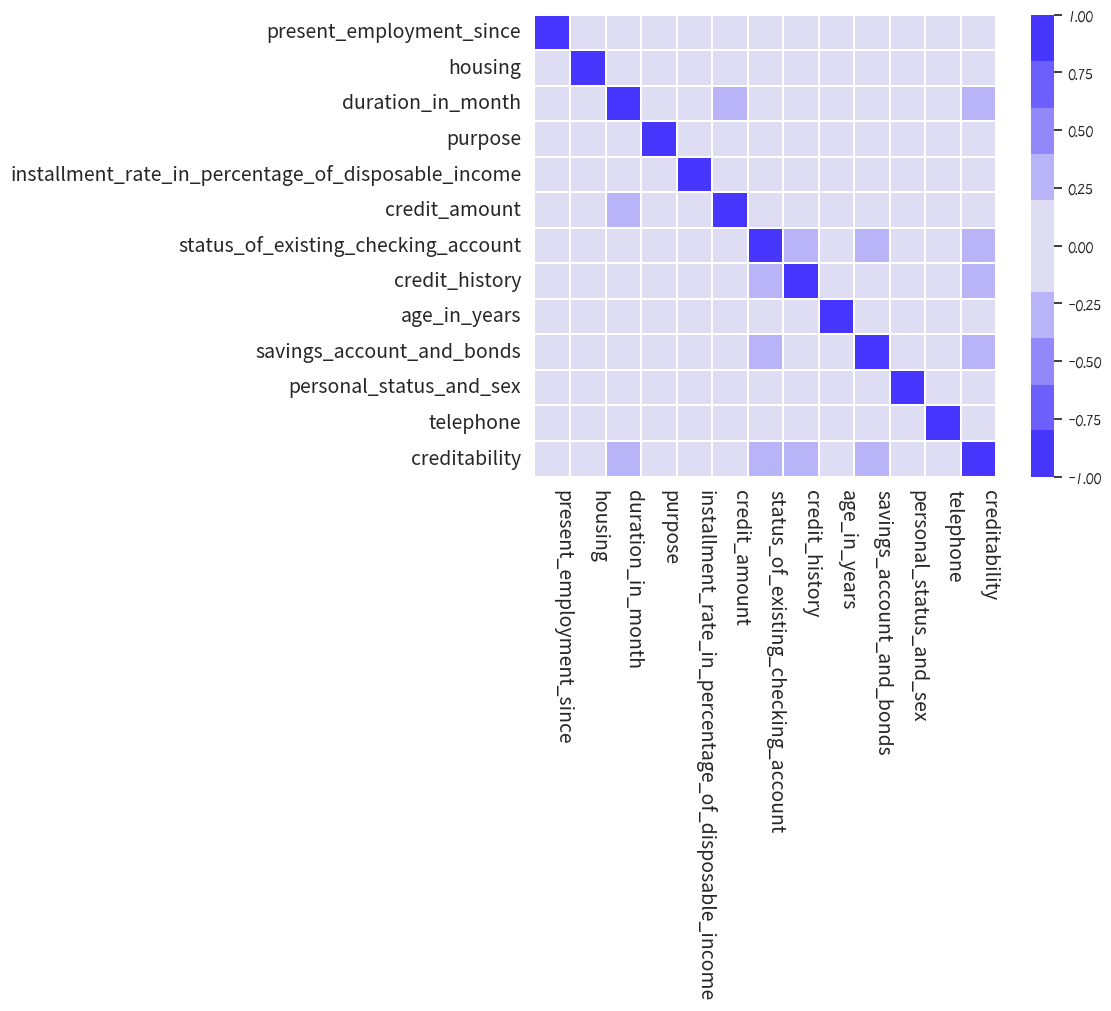

In [ ]:
_ = sp.corr_plot(woe_train, annot=False, figure_size=(9, 6))

6 逻辑回归模型训练

In [ ]:
sp.ITLubberLogisticRegression?

Init signature:
sp.ITLubberLogisticRegression(
    target='target',
    penalty='l2',
    calculate_stats=True,
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver='lbfgs',
    max_iter=100,
    multi_class='auto',
    verbose=0,
    warm_start=False,
    n_jobs=None,
    l1_ratio=None,
)
Docstring:     
Extended Logistic Regression.
Extends [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
This class provides the following extra statistics, calculated on `.fit()` and accessible via `.summary()`:
- `cov_matrix_`: covariance matrix for the estimated parameters.
- `std_err_intercept_`: estimated uncertainty for the intercept
- `std_err_coef_`: estimated uncertainty for the coefficients
- `z_intercept_`: estimated z-statistic for the intercept
- `z_coef_`: estimated z-statistic for the coefficients
- `p_va

6.1 逻辑回归模型训练

In [ ]:
# 逻辑回归模型构建
logistic = sp.ITLubberLogisticRegression(target=target)
logistic

ITLubberLogisticRegression(target='creditability')

In [ ]:
# 训练
logistic.fit(woe_train)

# 预测
y_pred_train = logistic.predict_proba(woe_train.drop(columns=target))[:, 1]
y_pred_test = logistic.predict_proba(woe_test.drop(columns=target))[:, 1]

6.2 模型表现

In [ ]:
# 模型 KS、AUC 指标
logger.info(f"dataset: train\t KS: {sp.KS(y_pred_train, train[target])},\t AUC: {sp.AUC(y_pred_train, train[target])}")
logger.info(f"dataset: test\t KS: {sp.KS(y_pred_test, test[target])},\t AUC: {sp.AUC(y_pred_test, test[target])}")

[ 2023-05-24 14:27:22,344 ][ INFO ][ 842722522.py:<cell line: 2>:2 ] dataset: train	 KS: 0.5428571428571428,	 AUC: 0.8339844509232264
[ 2023-05-24 14:27:22,348 ][ INFO ][ 842722522.py:<cell line: 3>:3 ] dataset: test	 KS: 0.44285714285714284,	 AUC: 0.7657142857142857


In [ ]:
# 模型拟合情况
logistic.summary()

,Coef.,Std.Err,z,P>|z|,[ 0.025,0.975 ],VIF
const,-0.8448,0.0997,-8.4760,0.0000,-1.0402,-0.6495,1.0579
present_employment_since,1.0008,0.3189,3.1386,0.0017,0.3758,1.6258,1.0189
housing,0.5324,0.3161,1.6841,0.0922,-0.0872,1.1520,1.0396
duration_in_month,0.7654,0.2148,3.5641,0.0004,0.3445,1.1863,1.2228
purpose,0.9620,0.2788,3.4509,0.0006,0.4156,1.5083,1.0268
installment_rate_in_percentage_of_disposable_income,1.3444,0.4969,2.7054,0.0068,0.3704,2.3184,1.0943
credit_amount,1.0240,0.3108,3.2947,0.0010,0.4148,1.6331,1.2106
status_of_existing_checking_account,0.7416,0.1208,6.1404,0.0000,0.5049,0.9783,1.1611
credit_history,0.7360,0.1768,4.1620,0.0000,0.3894,1.0825,1.0741
age_in_years,0.8550,0.3165,2.7014,0.0069,0.2347,1.4754,1.0529


In [ ]:
# 模型报告
logistic.report(woe_train)

,desc,precision,recall,f1-score,support
0,好客户,0.8228,0.9000,0.8596,490.0000
1,坏客户,0.7012,0.5476,0.6150,210.0000
2,macro avg,0.7620,0.7238,0.7373,700.0000
3,weighted avg,0.7863,0.7943,0.7862,700.0000
4,accuracy,,,0.7943,700.0000


In [ ]:
# 模型报告
logistic.report(woe_test)

,desc,precision,recall,f1-score,support
0,好客户,0.7729,0.8429,0.8064,210.0000
1,坏客户,0.5352,0.4222,0.4720,90.0000
2,macro avg,0.6541,0.6325,0.6392,300.0000
3,weighted avg,0.7016,0.7167,0.7061,300.0000
4,accuracy,,,0.7167,300.0000


In [ ]:
# 模型 KS、ROC 曲线
sp.ks_plot?

Signature:
sp.ks_plot(
    score,
    target,
    title='',
    fontsize=14,
    figsize=(16, 8),
    save=None,
    colors=['#2639E9', '#F76E6C', '#FE7715'],
    anchor=0.945,
)
Docstring: <no docstring>
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/utils.py
Type:      function


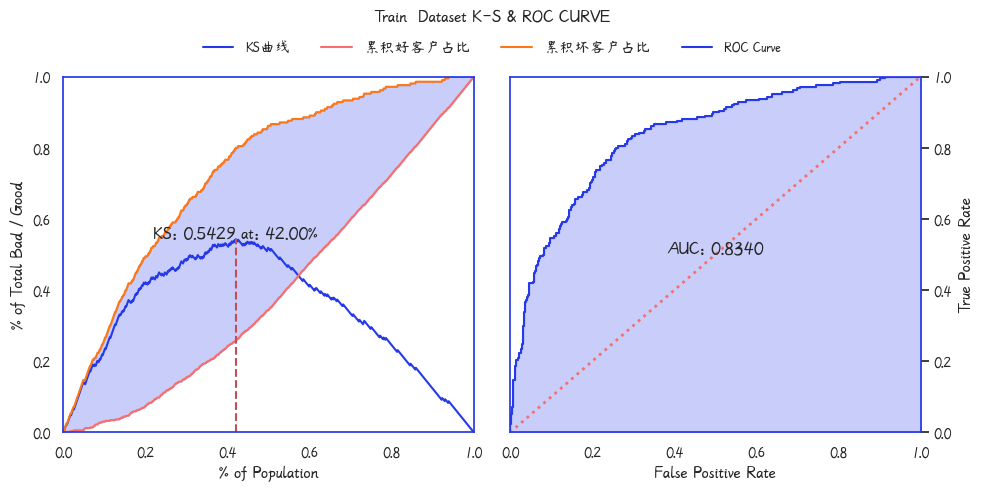

In [ ]:
_ = sp.ks_plot(y_pred_train, train[target], figsize=(10, 5), title="Train \tDataset")

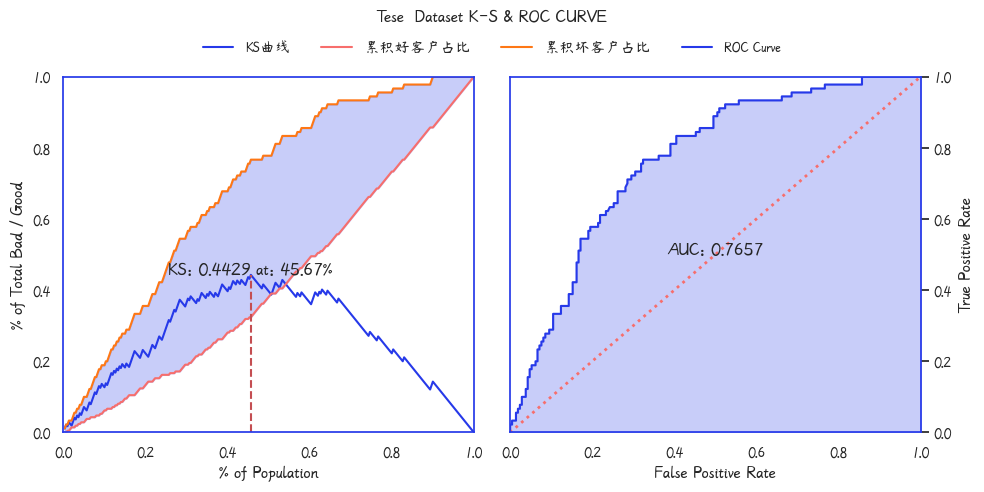

In [ ]:
_ = sp.ks_plot(y_pred_test, test[target], figsize=(10, 5), title="Tese \tDataset")

In [ ]:
# 概率分布图
sp.hist_plot?

Signature:
sp.hist_plot(
    score,
    y_true,
    figsize=(15, 10),
    bins=30,
    save=None,
    labels=['坏样本', '好样本'],
    anchor=1.1,
    fontsize=14,
    **kwargs,
)
Docstring: <no docstring>
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/utils.py
Type:      function


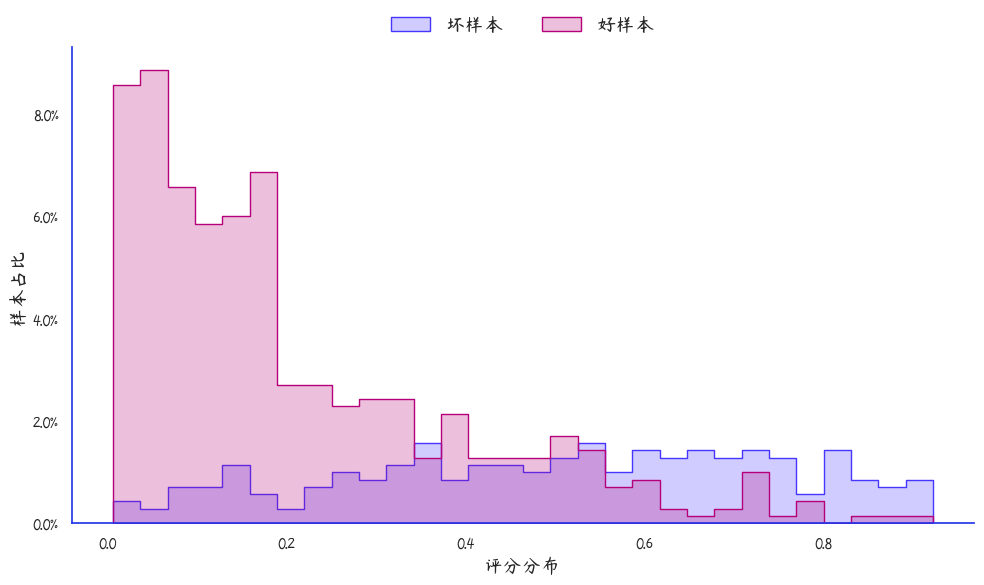

In [ ]:
_ = sp.hist_plot(y_pred_train, train[target], figsize=(10, 6))

6.3 入模特征分箱图

In [ ]:
# 特征分箱统计信息
sp.feature_bin_stats?

Signature:
sp.feature_bin_stats(
    data,
    feature,
    target='target',
    rules={},
    method='step',
    max_n_bins=None,
    min_bin_size=None,
    clip_v=None,
    desc='',
    verbose=0,
    combiner=None,
    ks=True,
    **kwargs,
)
Docstring: <no docstring>
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/utils.py
Type:      function


In [ ]:
# 特征分箱图
sp.bin_plot?

Signature:
sp.bin_plot(
    feature_table,
    desc='',
    figsize=(10, 6),
    colors=['#2639E9', '#F76E6C', '#FE7715'],
    save=None,
    anchor=0.945,
    max_len=35,
)
Docstring:
简单策略挖掘：特征分箱图

:param feature_table: 特征分箱的统计信息表，由 feature_bin_stats 运行得到
:param desc: 特征中文含义或者其他相关信息
:param figsize: 图像尺寸大小，传入一个tuple，默认 （10， 6）
:param colors: 图片主题颜色，默认即可
:param save: 图片保存路径

:return Figure
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/utils.py
Type:      function


In [ ]:
# 数据字段[可选]
feature_describe = pd.DataFrame([
    ["status_account", "支票账户状态"], ["duration", "借款周期"], ["credit_histor", "历史信用"], ["purpose", "借款目的"], ["amount", "信用额度"], ["svaing_account", "储蓄账户状态"], ["present_emp", "当前就业状态"], ["income_rate", "分期付款占可支配收入百分比"], ["personal_status", "性别与婚姻状态"], ["other_debtors", "他人担保信息"], ["residence_info", "现居住地"], ["property", "财产状态"], ["age", "年龄"], ["inst_plans", "其他分期情况"], ["housing", "房产状态"], ["num_credits", "信用卡数量"], ["job", "工作状态"], ["dependents", "赡养人数"], ["telephone", "电话号码注册情况"], ["foreign_worke", "是否有海外工作经历"],
], columns=["变量名称", "变量含义"])
feature_map = dict(zip(feature_describe["变量名称"], feature_describe["变量含义"]))

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,present_employment_since,逻辑回归入模变量,4 <= ... < 7 years,174,0.1740,135,0.1929,39,0.1300,0.2241,0.3944,0.0248,0.0752,0.7471,0.7471,135,39,-0.0629
1,present_employment_since,逻辑回归入模变量,"1 <= ... < 4 years,... >= 7 years",592,0.5920,424,0.6057,168,0.5600,0.2838,0.0785,0.0036,0.0752,0.9459,0.9008,559,207,-0.1086
2,present_employment_since,逻辑回归入模变量,"... < 1 year,unemployed",234,0.2340,141,0.2014,93,0.3100,0.3974,-0.4311,0.0468,0.0752,1.3248,1.0000,700,300,0.0000


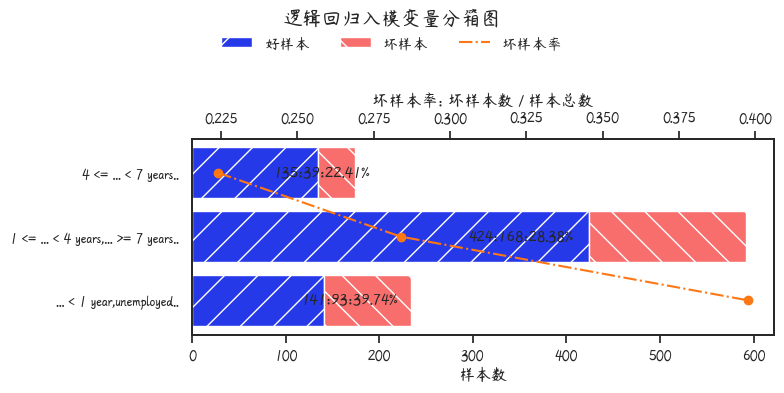

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,housing,房产状态,own,713,0.7130,527,0.7529,186,0.6200,0.2609,0.1942,0.0258,0.0833,0.8696,0.8696,527,186,-0.1329
1,housing,房产状态,rent,179,0.1790,109,0.1557,70,0.2333,0.3911,-0.4044,0.0314,0.0833,1.3035,0.9567,636,256,-0.0552
2,housing,房产状态,for free,108,0.1080,64,0.0914,44,0.1467,0.4074,-0.4726,0.0261,0.0833,1.3580,1.0000,700,300,0.0000


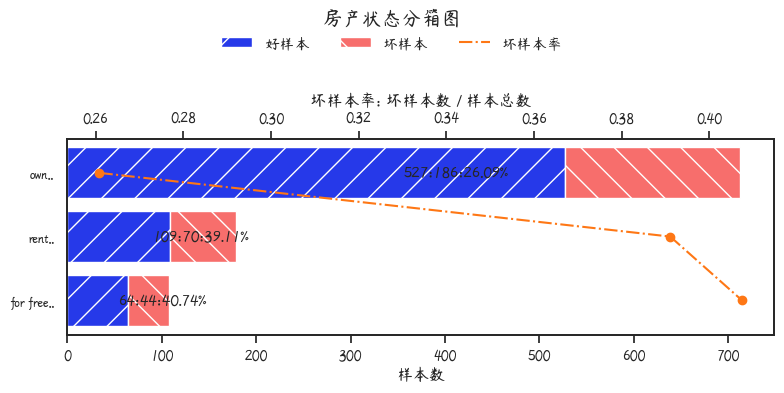

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,duration_in_month,逻辑回归入模变量,"[负无穷 , 12)",180,0.1800,153,0.2186,27,0.0900,0.1500,0.8873,0.1141,0.2152,0.5000,0.5000,153,27,-0.1286
1,duration_in_month,逻辑回归入模变量,"[12 , 27)",591,0.5910,420,0.6000,171,0.5700,0.2893,0.0513,0.0015,0.2152,0.9645,0.8560,573,198,-0.1586
2,duration_in_month,逻辑回归入模变量,"[27 , 正无穷)",229,0.2290,127,0.1814,102,0.3400,0.4454,-0.6281,0.0996,0.2152,1.4847,1.0000,700,300,0.0000


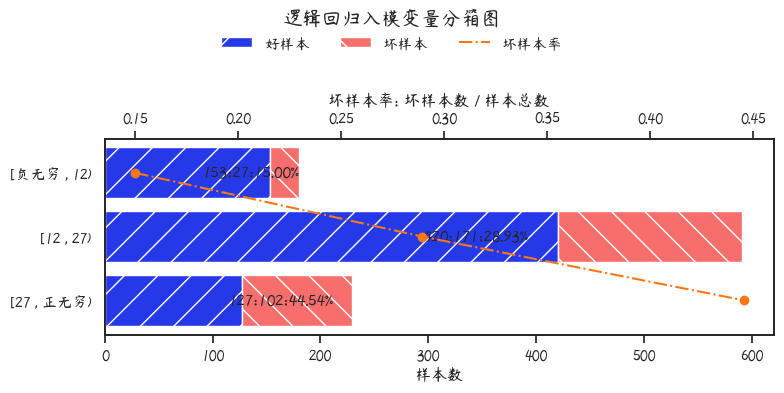

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,purpose,借款目的,"domestic appliances,car (used),retraining,radio/television",404,0.4040,320,0.4571,84,0.2800,0.2079,0.4902,0.0868,0.1470,0.6931,0.6931,320,84,-0.1771
1,purpose,借款目的,"furniture/equipment,repairs,business",300,0.3000,200,0.2857,100,0.3333,0.3333,-0.1542,0.0073,0.1470,1.1111,0.8712,520,184,-0.1295
2,purpose,借款目的,"others,education,car (new)",296,0.2960,180,0.2571,116,0.3867,0.3919,-0.4079,0.0528,0.1470,1.3063,1.0000,700,300,0.0000


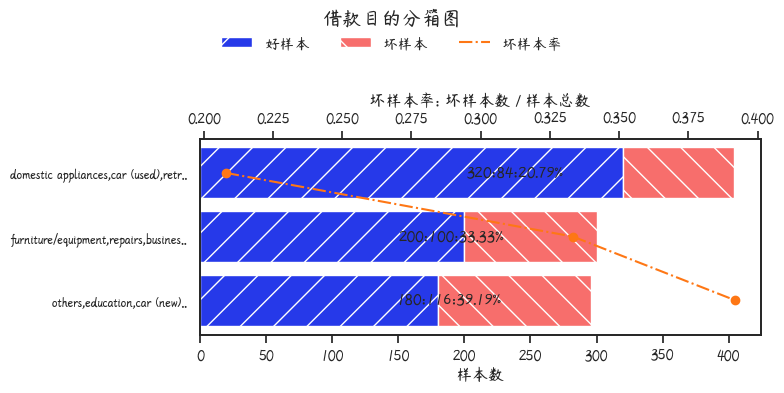

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,installment_rate_in_percentage_of_disposable_income,逻辑回归入模变量,"[负无穷 , 2)",136,0.1360,102,0.1457,34,0.1133,0.2500,0.2513,0.0081,0.0256,0.8333,0.8333,102,34,-0.0324
1,installment_rate_in_percentage_of_disposable_income,逻辑回归入模变量,"[2 , 4)",388,0.3880,281,0.4014,107,0.3567,0.2758,0.1182,0.0053,0.0256,0.9192,0.8969,383,141,-0.0771
2,installment_rate_in_percentage_of_disposable_income,逻辑回归入模变量,"[4 , 正无穷)",476,0.4760,317,0.4529,159,0.5300,0.3340,-0.1573,0.0121,0.0256,1.1134,1.0000,700,300,0.0000


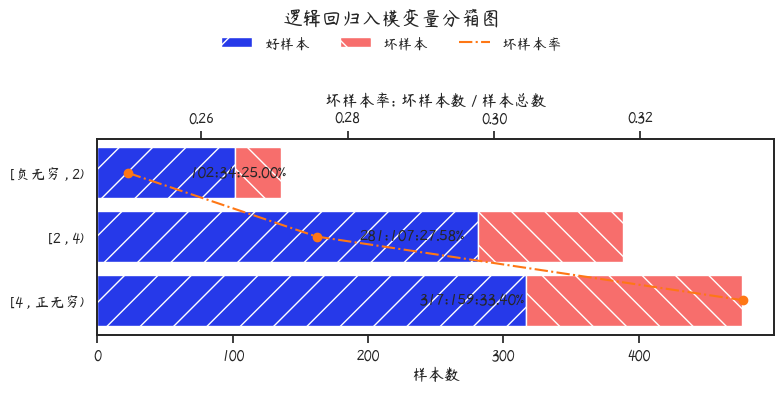

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,credit_amount,逻辑回归入模变量,"[负无穷 , 1845)",383,0.3830,277,0.3957,106,0.3533,0.2768,0.1133,0.0048,0.1315,0.9225,0.9225,277,106,-0.0424
1,credit_amount,逻辑回归入模变量,"[1845 , 3914)",357,0.3570,274,0.3914,83,0.2767,0.2325,0.3470,0.0398,0.1315,0.7750,0.8514,551,189,-0.1571
2,credit_amount,逻辑回归入模变量,"[3914 , 正无穷)",260,0.2600,149,0.2129,111,0.3700,0.4269,-0.5529,0.0869,0.1315,1.4231,1.0000,700,300,0.0000


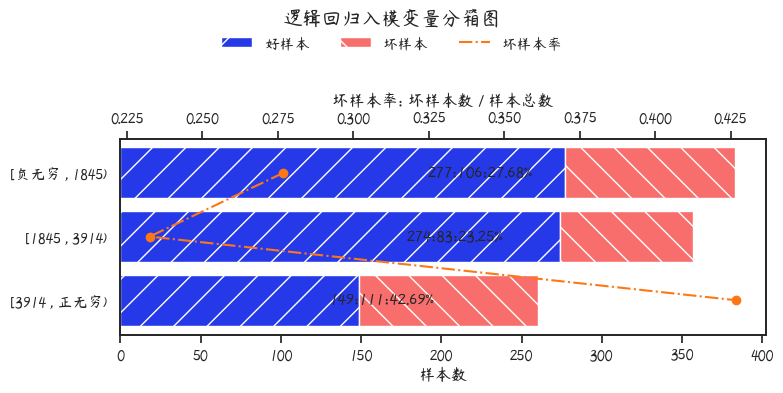

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,status_of_existing_checking_account,逻辑回归入模变量,"... >= 200 DM / salary assignments for at least 1 year,no checking account",457,0.4570,397,0.5671,60,0.2000,0.1313,1.0423,0.3827,0.6348,0.4376,0.4376,397,60,-0.3671
1,status_of_existing_checking_account,逻辑回归入模变量,0 <= ... < 200 DM,269,0.2690,164,0.2343,105,0.3500,0.3903,-0.4014,0.0464,0.6348,1.3011,0.7576,561,165,-0.2514
2,status_of_existing_checking_account,逻辑回归入模变量,... < 0 DM,274,0.2740,139,0.1986,135,0.4500,0.4927,-0.8181,0.2057,0.6348,1.6423,1.0000,700,300,0.0000


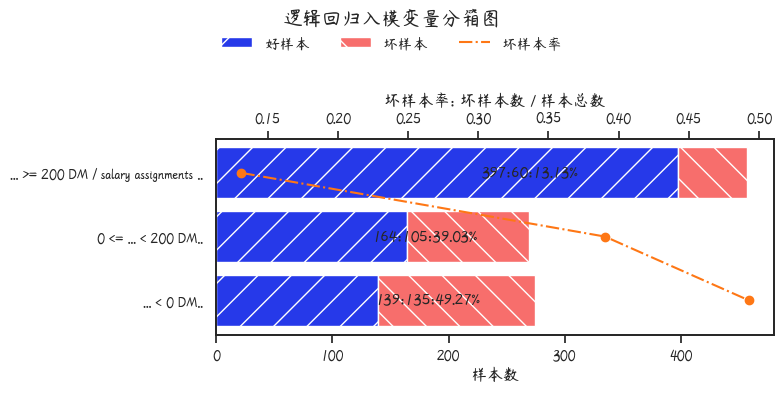

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,credit_history,逻辑回归入模变量,critical account/ other credits existing (not at this bank),293,0.2930,243,0.3471,50,0.1667,0.1706,0.7337,0.1324,0.2918,0.5688,0.5688,243,50,-0.1805
1,credit_history,逻辑回归入模变量,"existing credits paid back duly till now,delay in paying off in the past",618,0.6180,421,0.6014,197,0.6567,0.3188,-0.0879,0.0049,0.2918,1.0626,0.9038,664,247,-0.1252
2,credit_history,逻辑回归入模变量,"all credits at this bank paid back duly,no credits taken/ all credits paid back duly",89,0.0890,36,0.0514,53,0.1767,0.5955,-1.2341,0.1546,0.2918,1.9850,1.0000,700,300,0.0000


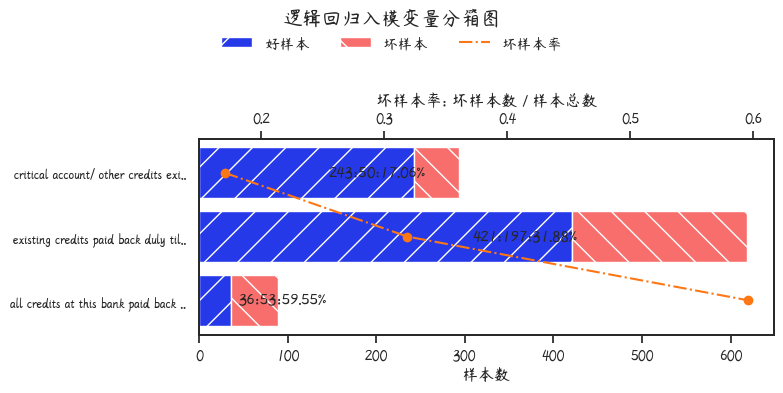

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,age_in_years,逻辑回归入模变量,"[负无穷 , 26)",190,0.1900,110,0.1571,80,0.2667,0.4211,-0.5288,0.0579,0.0767,1.4035,1.4035,110,80,0.1095
1,age_in_years,逻辑回归入模变量,"[26 , 45)",609,0.6090,439,0.6271,170,0.5667,0.2791,0.1014,0.0061,0.0767,0.9305,1.0430,549,250,0.0490
2,age_in_years,逻辑回归入模变量,"[45 , 正无穷)",201,0.2010,151,0.2157,50,0.1667,0.2488,0.2580,0.0127,0.0767,0.8292,1.0000,700,300,0.0000


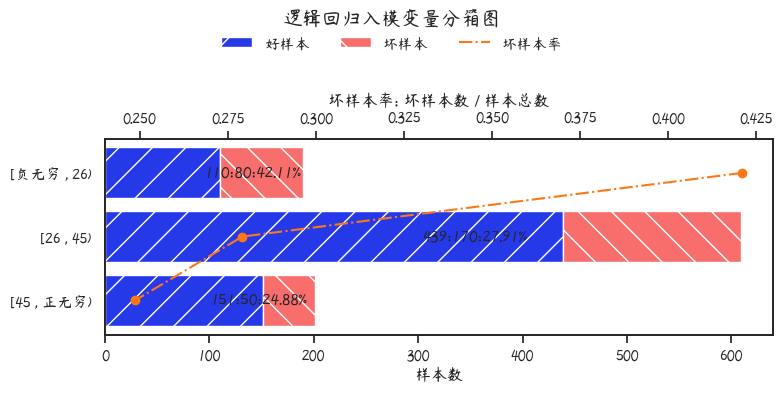

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,savings_account_and_bonds,逻辑回归入模变量,"500 <= ... < 1000 DM,... >= 1000 DM,unknown/ no savings account",294,0.2940,245,0.3500,49,0.1633,0.1667,0.7621,0.1423,0.1910,0.5556,0.5556,245,49,-0.1867
1,savings_account_and_bonds,逻辑回归入模变量,100 <= ... < 500 DM,103,0.1030,69,0.0986,34,0.1133,0.3301,-0.1396,0.0021,0.1910,1.1003,0.6969,314,83,-0.1719
2,savings_account_and_bonds,逻辑回归入模变量,... < 100 DM,603,0.6030,386,0.5514,217,0.7233,0.3599,-0.2714,0.0466,0.1910,1.1996,1.0000,700,300,0.0000


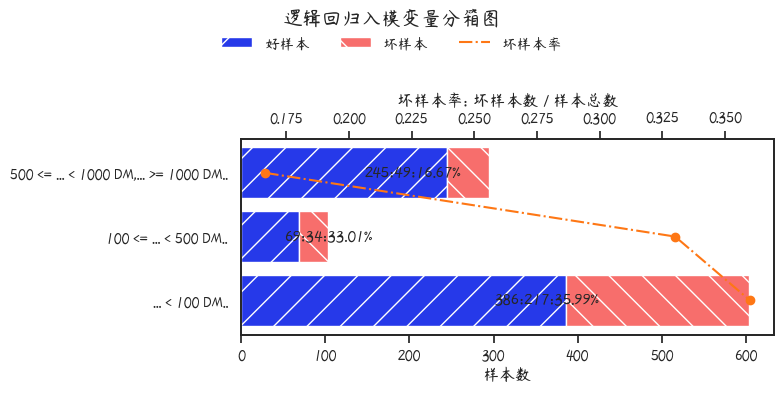

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,personal_status_and_sex,逻辑回归入模变量,"male : divorced/separated,female : divorced/separated/married",360,0.3600,259,0.3700,101,0.3367,0.2806,0.0944,0.0031,0.0064,0.9352,0.9352,259,101,-0.0333
1,personal_status_and_sex,逻辑回归入模变量,male : single,548,0.5480,380,0.5429,168,0.5600,0.3066,-0.0311,0.0005,0.0064,1.0219,0.9875,639,269,-0.0162
2,personal_status_and_sex,逻辑回归入模变量,male : married/widowed,92,0.0920,61,0.0871,31,0.1033,0.3370,-0.1704,0.0028,0.0064,1.1232,1.0000,700,300,0.0000


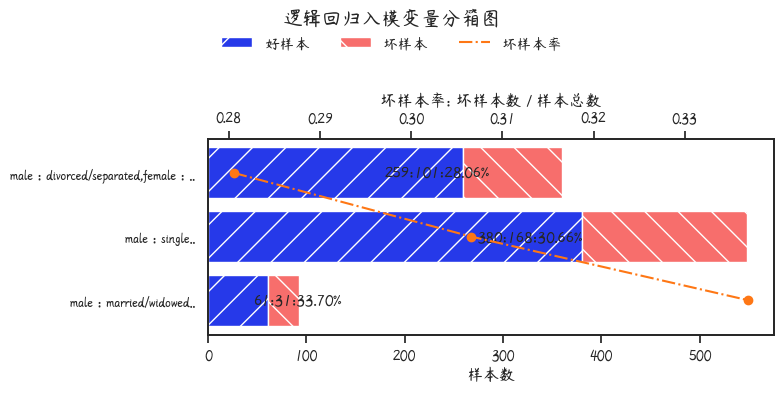

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,telephone,电话号码注册情况,"yes, registered under the customers name",404,0.4040,291,0.4157,113,0.3767,0.2797,0.0986,0.0039,0.0064,0.9323,0.9323,291,113,-0.0390
1,telephone,电话号码注册情况,none,596,0.5960,409,0.5843,187,0.6233,0.3138,-0.0647,0.0025,0.0064,1.0459,1.0000,700,300,0.0000


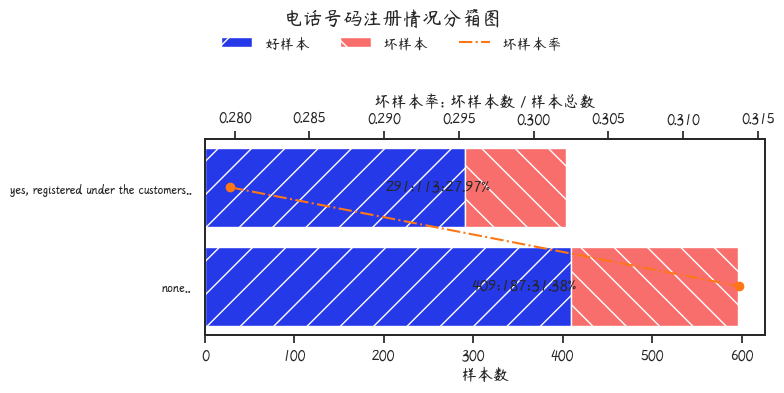

In [ ]:
for col in logistic.feature_names_in_:
    feature_table = sp.feature_bin_stats(data, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=feature_pipeline.named_steps["combiner"])
    _ = sp.bin_plot(feature_table, desc=feature_map.get(col, "") or "逻辑回归入模变量", figsize=(8, 4))
    
    display(feature_table)
    plt.show()

7 评分卡模型转换

In [ ]:
sp.ScoreCard?

Init signature:
sp.ScoreCard(
    target='target',
    pdo=60,
    rate=2,
    base_odds=35,
    base_score=750,
    combiner={},
    transer=None,
    pretrain_lr=None,
    pipeline=None,
    **kwargs,
)
Docstring:     
Base class for all estimators in scikit-learn.

Notes
-----
All estimators should specify all the parameters that can be set
at the class level in their ``__init__`` as explicit keyword
arguments (no ``*args`` or ``**kwargs``).
Init docstring:
评分卡模型转换

Args:
    target: 数据集中标签名称，默认 target
    pdo: odds 每增加 rate 倍时减少 pdo 分，默认 60
    rate: 倍率
    base_odds: 基础 odds，通常根据业务经验设置的基础比率（违约概率/正常概率），估算方法：（1-样本坏客户占比）/坏客户占比，默认 35，即 35:1 => 0.972 => 坏样本率 2.8%
    base_score: 基础 odds 对应的分数，默认 750
    combiner: 分箱转换器，传入 pipeline 时可以为None
    transer: woe转换器，传入 pipeline 时可以为None
    pretrain_lr: 预训练好的逻辑回归模型，可以不传
    pipeline: 训练好的 pipeline，必须包含 Combiner 和 WOETransformer
    **kwargs: 其他相关参数，具体参考 toad.ScoreCard
File:           ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/mod

7.1 评分卡转换

In [ ]:
# 逻辑回归模型转评分卡
card = sp.ScoreCard(target=target, pipeline=feature_pipeline, pretrain_lr=logistic)
card

ScoreCard(combiner=<toad.transform.Combiner object at 0x7f88b27ed7c0>,
          pipeline=Pipeline(steps=[('preprocessing_select',
                                    FeatureSelection(target='creditability')),
                                   ('combiner',
                                    Combiner(min_bin_size=0.2,
                                             rules={'age_in_years': array([26, 45]),
                                                    'credit_amount': array([1845, 3914]),
                                                    'credit_history': array([list(['critical account/ other credits existing (not at this bank)...
                                             target='creditability')),
                                   ('transform',
                                    WOETransformer(exclude=[],
                                                   target='creditability')),
                                   ('processing_select',
                                    FeatureSelection(engine='toad',
                                                     target='creditability')),
                                   ('stepwise',
                                    StepwiseSelection(target='creditability'))]),
          pretrain_lr=ITLubberLogisticRegression(target='creditability'),
          target='creditability',
          transer=<toad.transform.WOETransformer object at 0x7f88b27ed8e0>)

In [ ]:
# 训练
card.fit(woe_train)

# 预测
train["score"] = card.predict(train)
test["score"] = card.predict(test)

7.2 评分卡信息

In [ ]:
# 获取评分卡刻度信息
card.scorecard_scale()

,刻度项,刻度值,备注
0,base_odds,35.0000,根据业务经验设置的基础比率（违约概率/正常概率），估算方法：（1-样本坏客户占比）/坏客户占比
1,base_score,750.0000,基础ODDS对应的分数
2,rate,2.0000,设置分数的倍率
3,pdo,60.0000,表示分数增长PDO时，ODDS值增长到RATE倍
4,B,442.2430,补偿值，计算方式：pdo / ln(rate)
5,A,86.5617,刻度，计算方式：base_score - B * ln(base_odds)


In [ ]:
# 获取评分卡明细
card.scorecard_points(feature_map=feature_map)

,变量名称,变量含义,变量分箱,对应分数
0,present_employment_since,,4 <= ... < 7 years,91.3583
1,present_employment_since,,"... >= 7 years,1 <= ... < 4 years",44.8540
2,present_employment_since,,"unemployed,... < 1 year",6.9324
3,housing,房产状态,own,52.4593
4,housing,房产状态,rent,24.7297
5,housing,房产状态,for free,17.5164
6,duration_in_month,,[-inf ~ 12),105.5238
7,duration_in_month,,[12 ~ 27),47.5189
8,duration_in_month,,[27 ~ inf),-0.5322
9,purpose,借款目的,"domestic appliances,retraining,car (used),radio/television",80.3360


7.3 评分效果

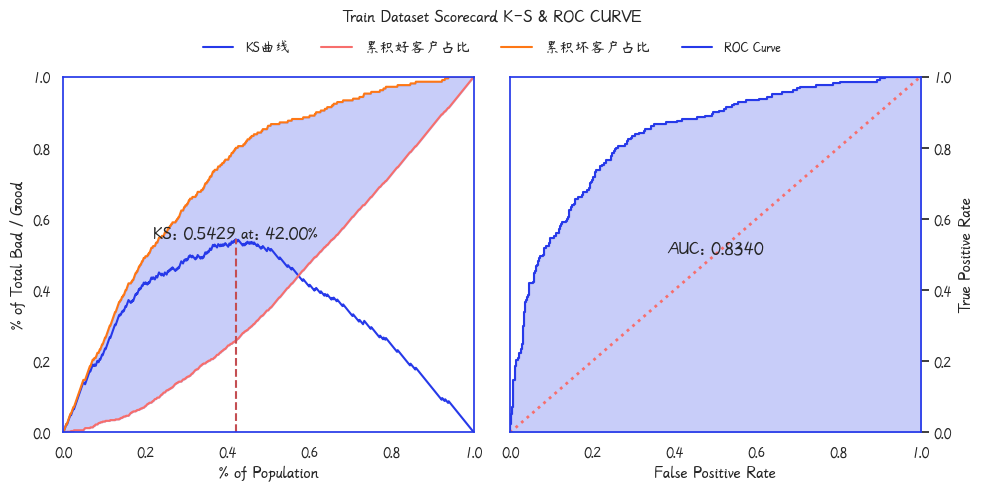

In [ ]:
# 评分卡 KS、ROC 曲线
_ = sp.ks_plot(train["score"], train[target], figsize=(10, 5), title="Train Dataset Scorecard")

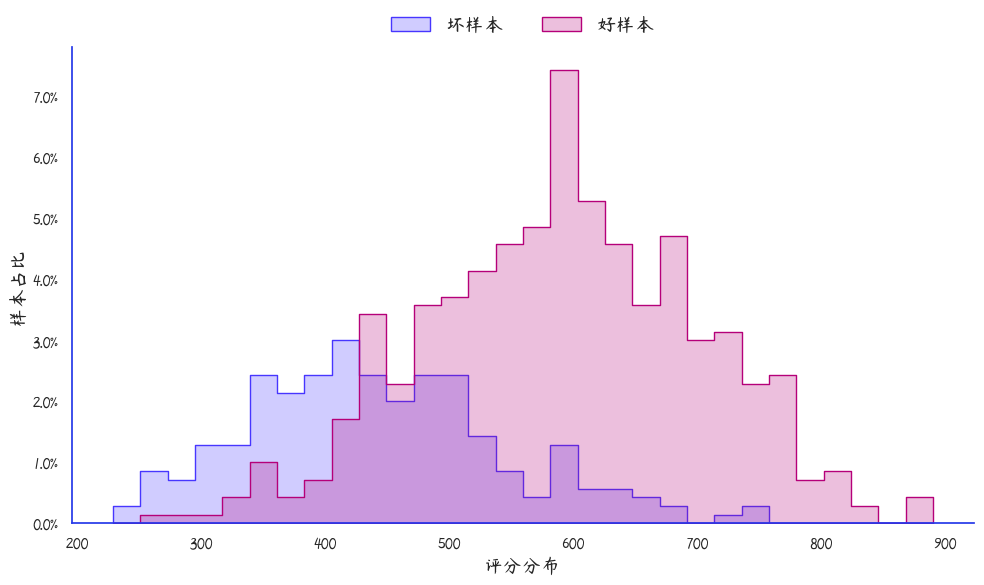

In [ ]:
# 评分分布情况
_ = sp.hist_plot(train["score"], train[target], figsize=(10, 6))

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,score,训练集模型评分,"[负无穷 , 300)",18.0000,0.0257,3.0000,0.0061,15.0000,0.0714,0.8333,-2.4567,0.1604,1.8774,2.7778,2.7778,3.0000,15.0000,0.0653
1,score,训练集模型评分,"[300 , 400)",77.0000,0.1100,15.0000,0.0306,62.0000,0.2952,0.8052,-2.2664,0.5997,1.8774,2.6840,2.7018,18.0000,77.0000,0.3299
2,score,训练集模型评分,"[400 , 500)",163.0000,0.2329,85.0000,0.1735,78.0000,0.3714,0.4785,-0.7614,0.1507,1.8774,1.5951,2.0026,103.0000,155.0000,0.5279
3,score,训练集模型评分,"[500 , 600)",194.0000,0.2771,157.0000,0.3204,37.0000,0.1762,0.1907,0.5980,0.0862,1.8774,0.6357,1.4159,260.0000,192.0000,0.3837
4,score,训练集模型评分,"[600 , 700)",161.0000,0.2300,146.0000,0.2980,15.0000,0.0714,0.0932,1.4282,0.3235,1.8774,0.3106,1.1256,406.0000,207.0000,0.1571
5,score,训练集模型评分,"[700 , 800)",75.0000,0.1071,72.0000,0.1469,3.0000,0.0143,0.0400,2.3307,0.3092,1.8774,0.1333,1.0174,478.0000,210.0000,0.0245
6,score,训练集模型评分,"[800 , 正无穷)",12.0000,0.0171,12.0000,0.0245,0.0000,0.0000,0.0000,10.1060,0.2475,1.8774,0.0000,1.0000,490.0000,210.0000,0.0000


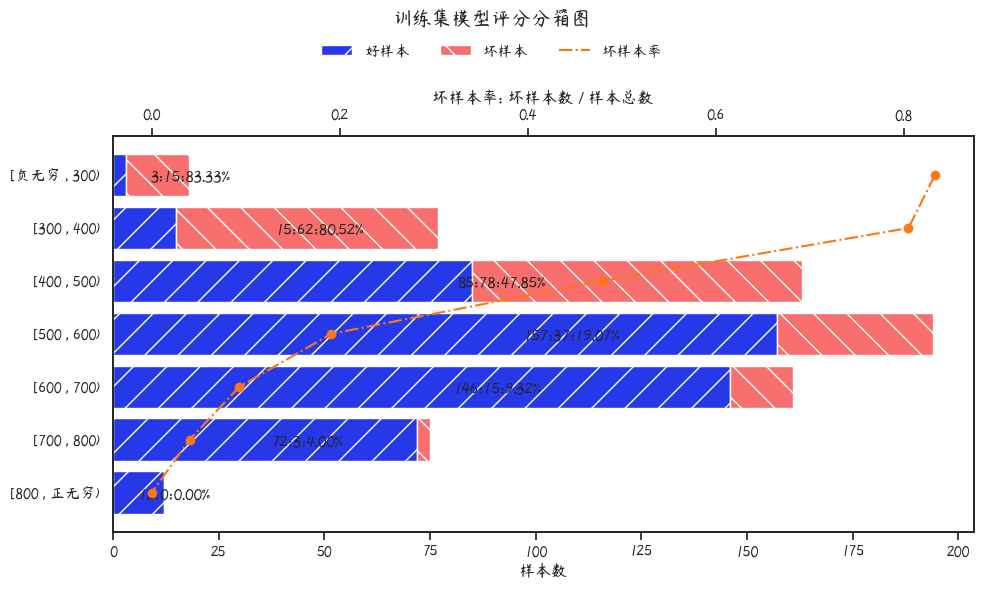

In [ ]:
# 训练集评分排序性
score_clip = card.score_clip(train["score"], clip=100)
score_table_train = sp.feature_bin_stats(train, "score", desc="训练集模型评分", target=target, rules=score_clip)
sp.bin_plot(score_table_train, desc="训练集模型评分", figsize=(10, 6))

display(score_table_train)

,指标名称,指标含义,分箱,样本总数,样本占比,好样本数,好样本占比,坏样本数,坏样本占比,坏样本率,分档WOE值,分档IV值,指标IV值,LIFT值,累积LIFT值,累积好样本数,累积坏样本数,分档KS值
0,score,测试集模型评分,"[负无穷 , 300)",10.0000,0.0333,4.0000,0.0190,6.0000,0.0667,0.6000,-1.2528,0.0597,1.1879,2.0000,2.0000,4.0000,6.0000,0.0476
1,score,测试集模型评分,"[300 , 400)",36.0000,0.1200,16.0000,0.0762,20.0000,0.2222,0.5556,-1.0704,0.1563,1.1879,1.8519,1.8841,20.0000,26.0000,0.1937
2,score,测试集模型评分,"[400 , 500)",71.0000,0.2367,36.0000,0.1714,35.0000,0.3889,0.4930,-0.8191,0.1781,1.1879,1.6432,1.7379,56.0000,61.0000,0.4111
3,score,测试集模型评分,"[500 , 600)",79.0000,0.2633,57.0000,0.2714,22.0000,0.2444,0.2785,0.1047,0.0028,1.1879,0.9283,1.4116,113.0000,83.0000,0.3841
4,score,测试集模型评分,"[600 , 700)",65.0000,0.2167,60.0000,0.2857,5.0000,0.0556,0.0769,1.6376,0.3769,1.1879,0.2564,1.1239,173.0000,88.0000,0.1540
5,score,测试集模型评分,"[700 , 800)",36.0000,0.1200,34.0000,0.1619,2.0000,0.0222,0.0556,1.9859,0.2774,1.1879,0.1852,1.0101,207.0000,90.0000,0.0143
6,score,测试集模型评分,"[800 , 正无穷)",3.0000,0.0100,3.0000,0.0143,0.0000,0.0000,0.0000,9.5670,0.1367,1.1879,0.0000,1.0000,210.0000,90.0000,0.0000


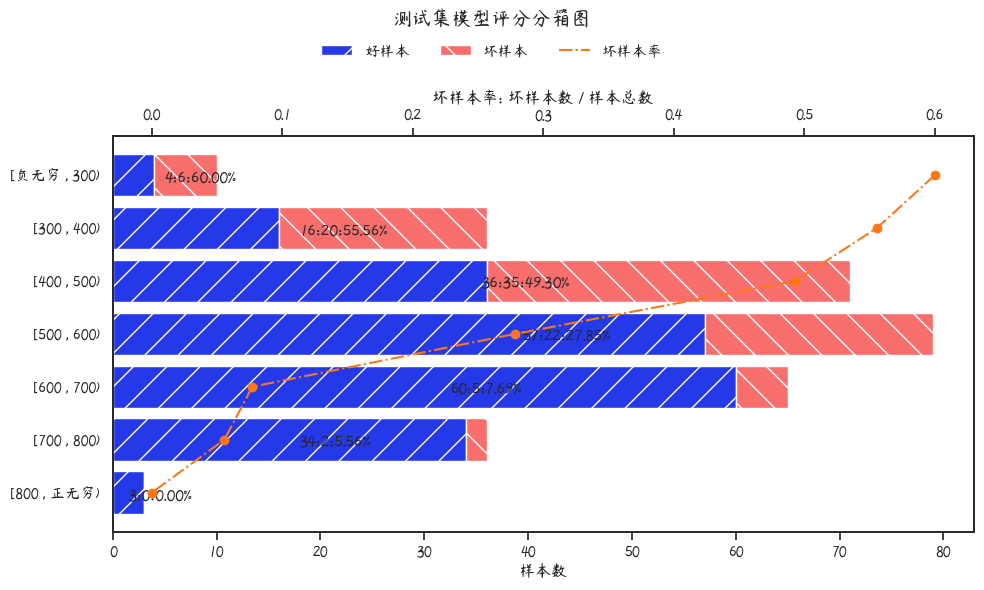

In [ ]:
# 测试集评分排序性
score_table_test = sp.feature_bin_stats(test, "score", desc="测试集模型评分", target=target, rules=score_clip)
sp.bin_plot(score_table_test, desc="测试集模型评分", figsize=(10, 6))

display(score_table_test)

7.3 评分卡稳定性

In [ ]:
sp.psi_plot?

Signature:
sp.psi_plot(
    expected,
    actual,
    labels=['预期', '实际'],
    save=None,
    colors=['#2639E9', '#F76E6C', '#FE7715'],
    figsize=(15, 8),
    anchor=0.94,
    width=0.35,
    result=False,
    plot=True,
    max_len=None,
)
Docstring: <no docstring>
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/utils.py
Type:      function


In [ ]:
sp.csi_plot?

Signature:
sp.csi_plot(
    expected,
    actual,
    score_bins,
    labels=['预期', '实际'],
    save=None,
    colors=['#2639E9', '#F76E6C', '#FE7715'],
    figsize=(15, 8),
    anchor=0.94,
    width=0.35,
    result=False,
    plot=True,
    max_len=None,
)
Docstring: <no docstring>
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/utils.py
Type:      function


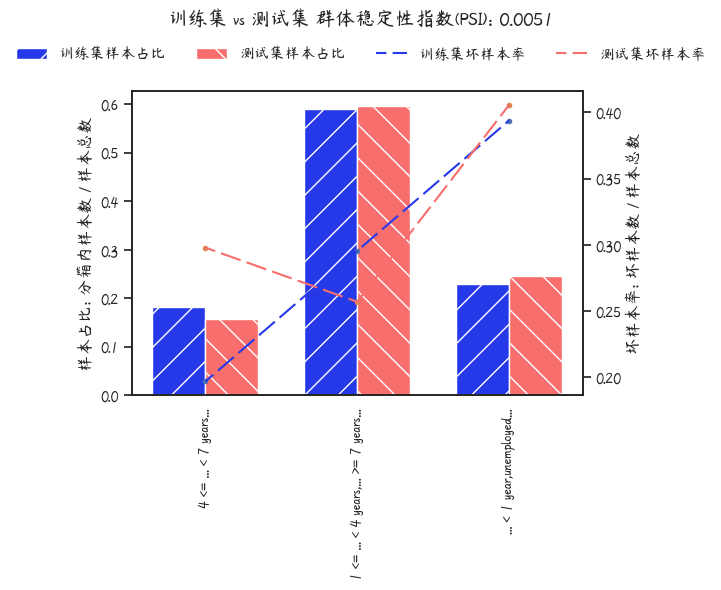

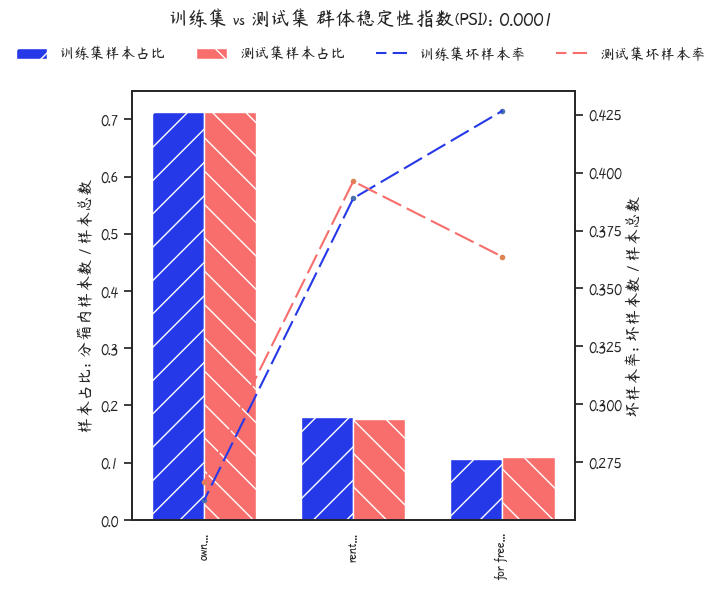

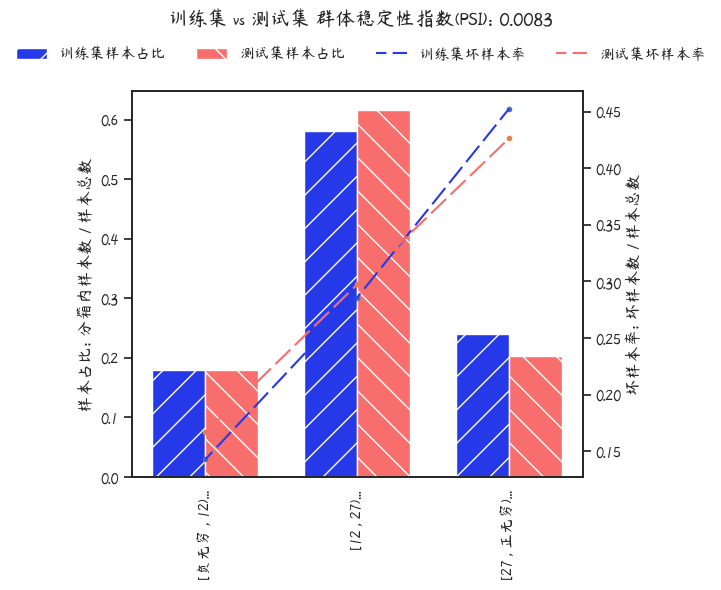

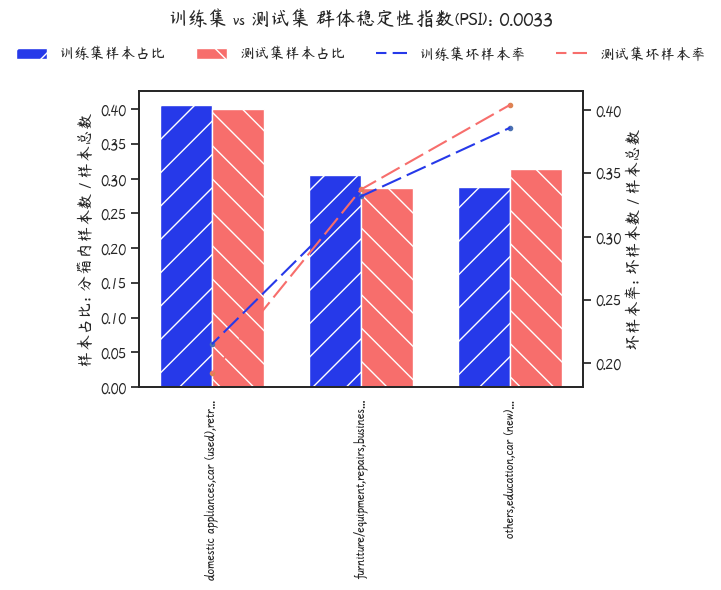

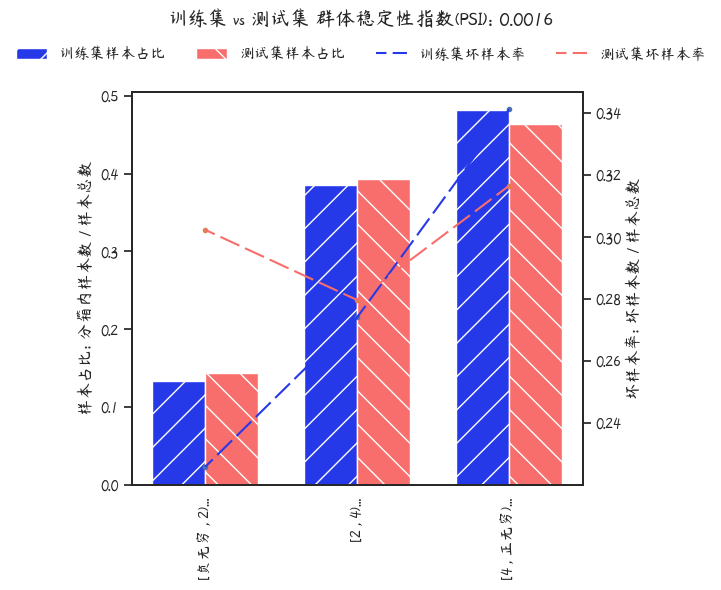

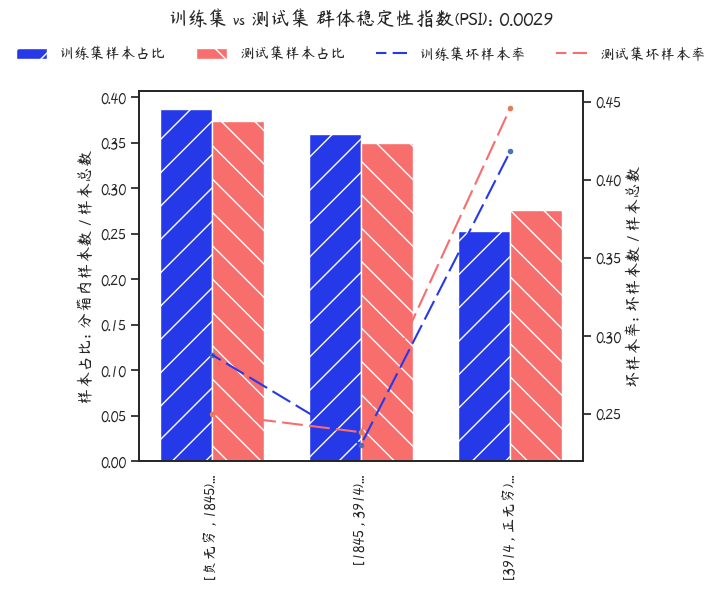

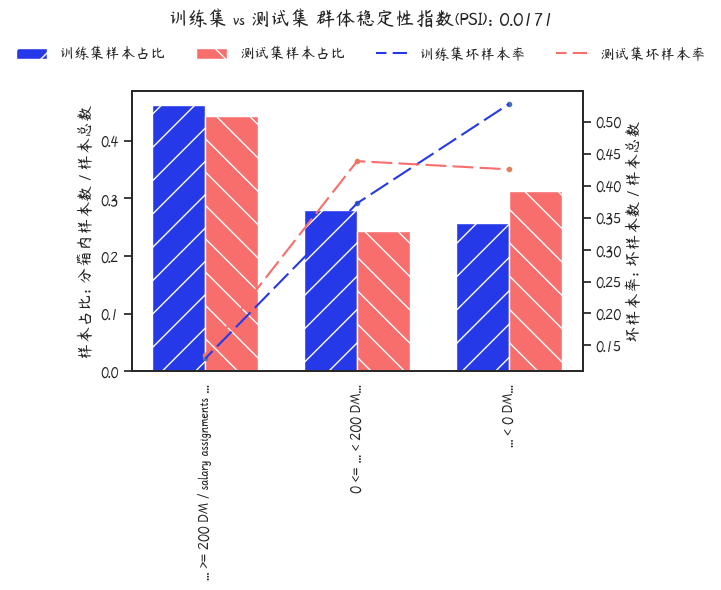

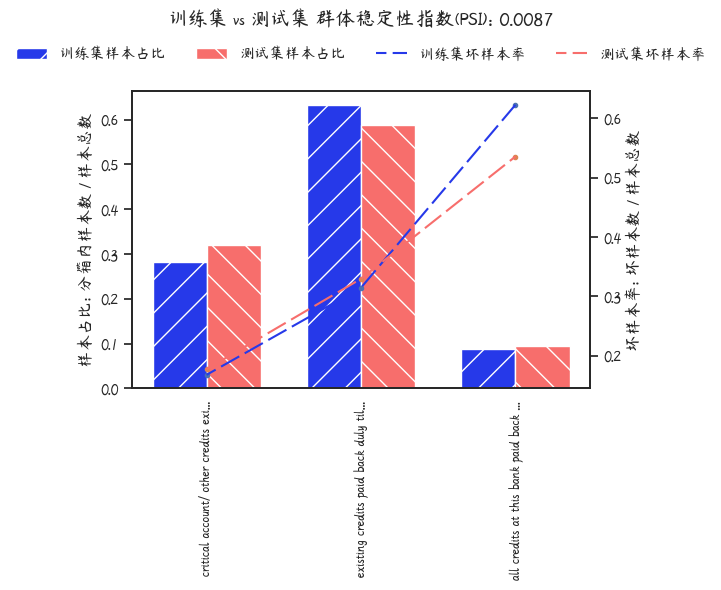

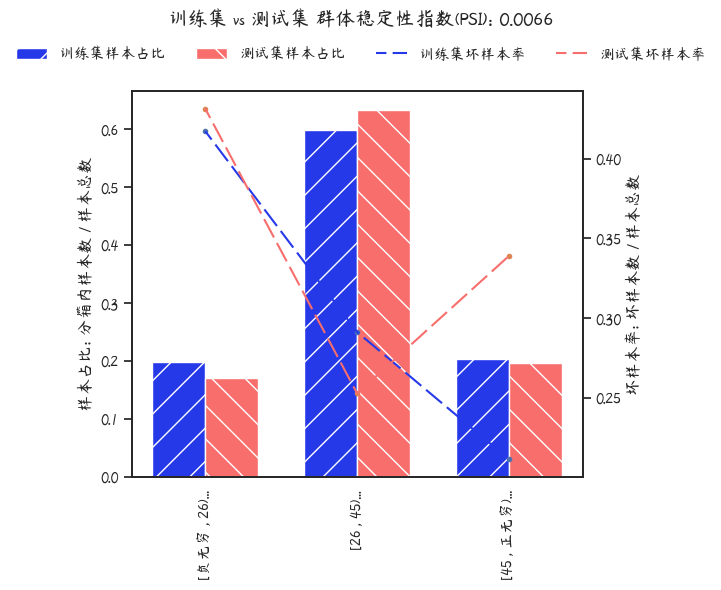

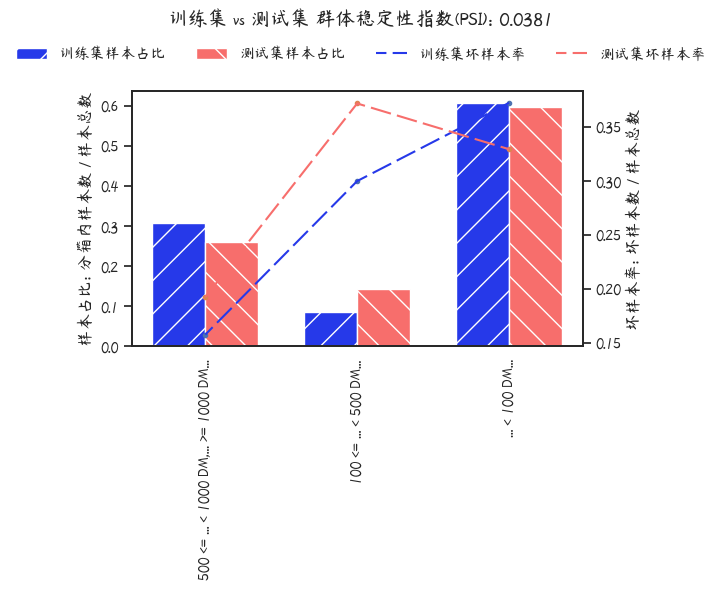

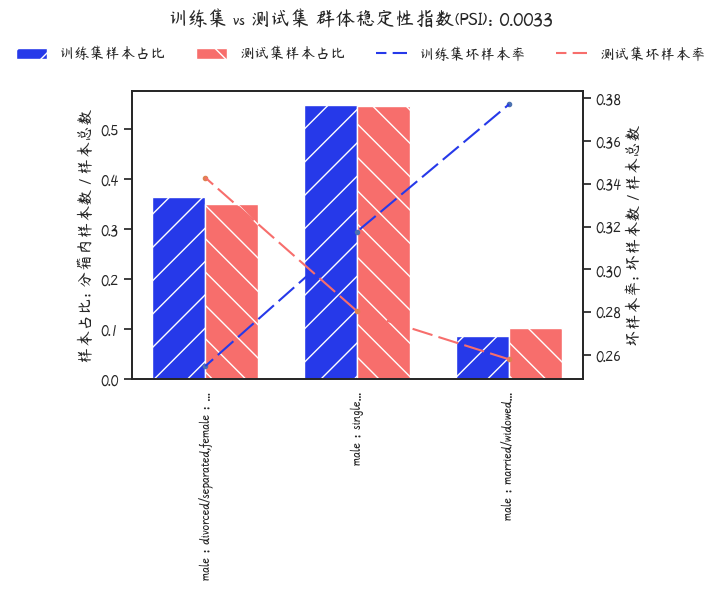

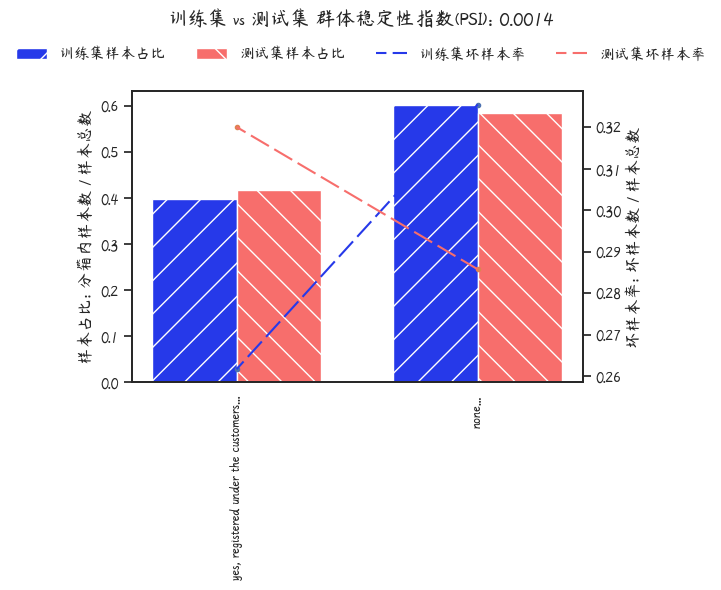

In [ ]:
for col in card._feature_names:
    feature_table_train = sp.feature_bin_stats(train, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=feature_pipeline.named_steps["combiner"])
    feature_table_test = sp.feature_bin_stats(test, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=feature_pipeline.named_steps["combiner"])
    
    psi_table = sp.psi_plot(feature_table_train, feature_table_test, result=True, plot=True, max_len=35, figsize=(6, 6), labels=["训练集", "测试集"])

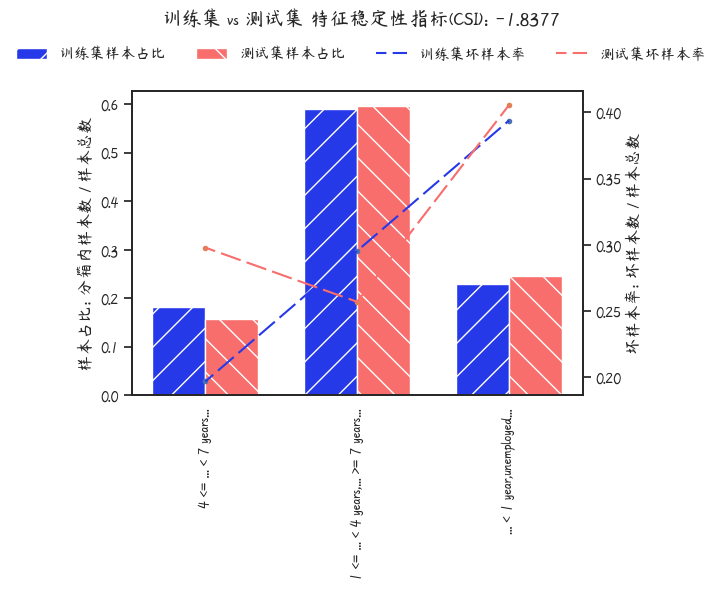

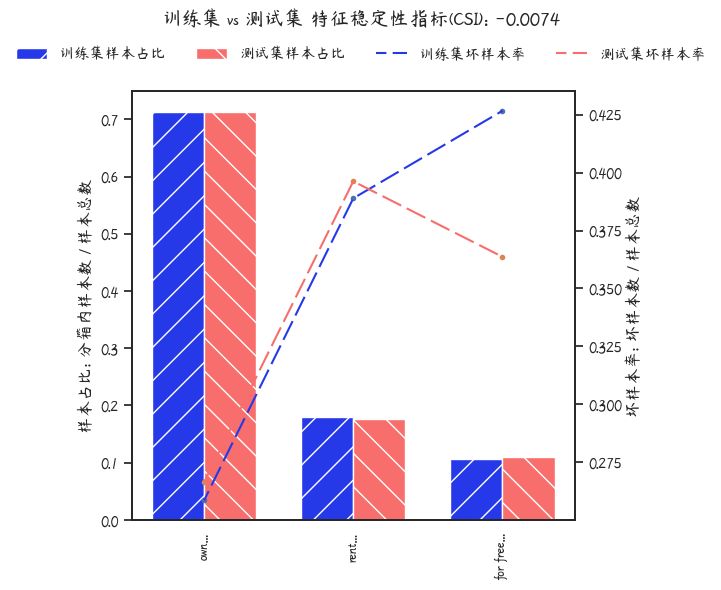

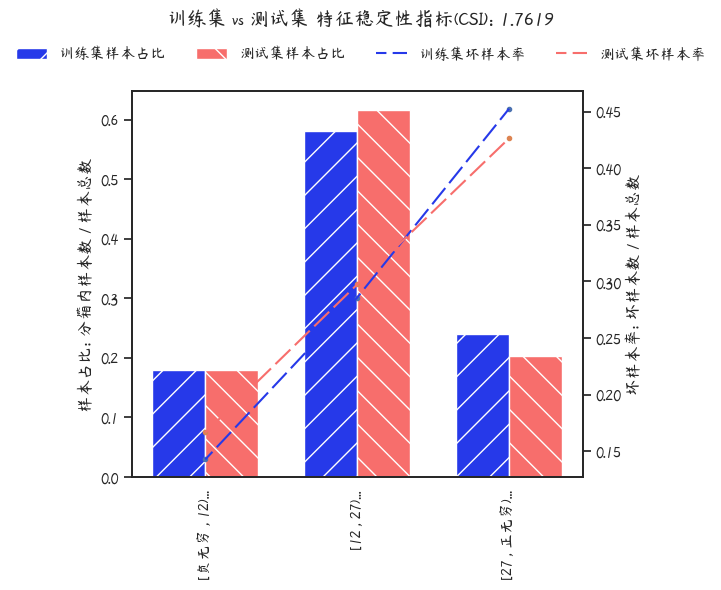

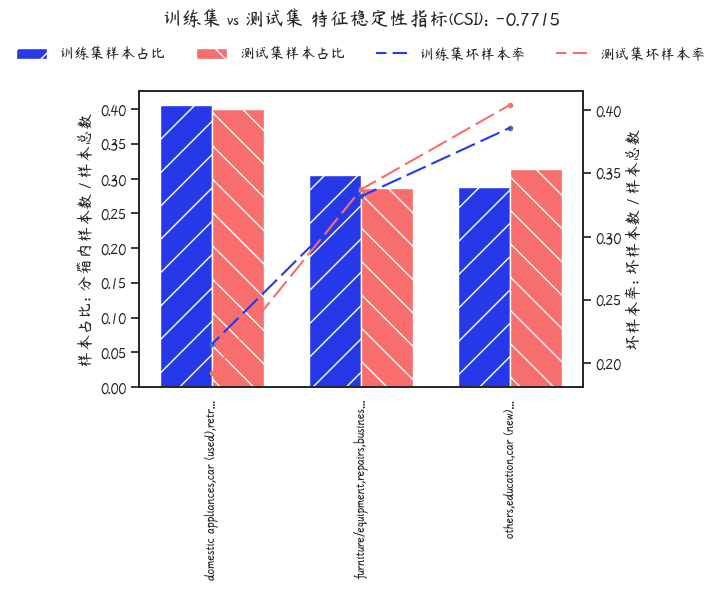

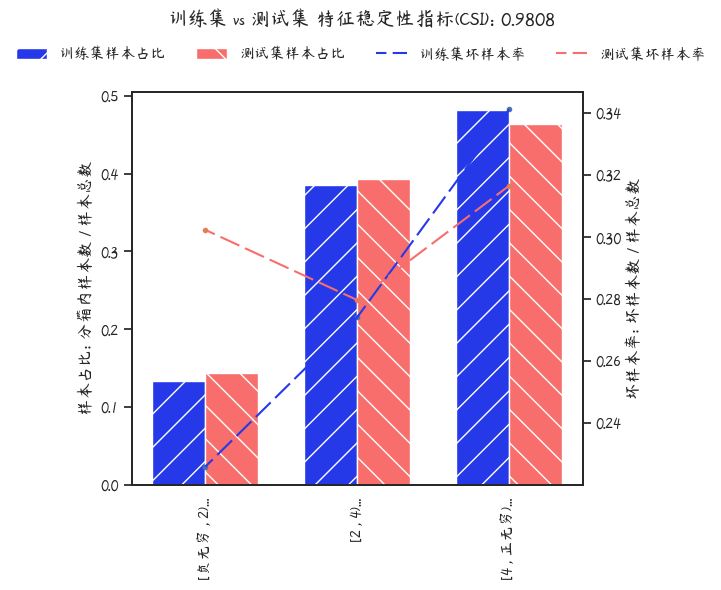

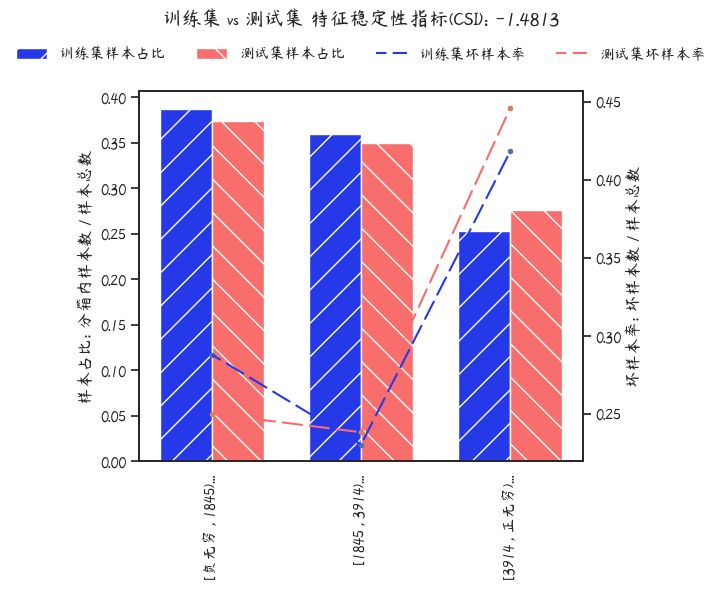

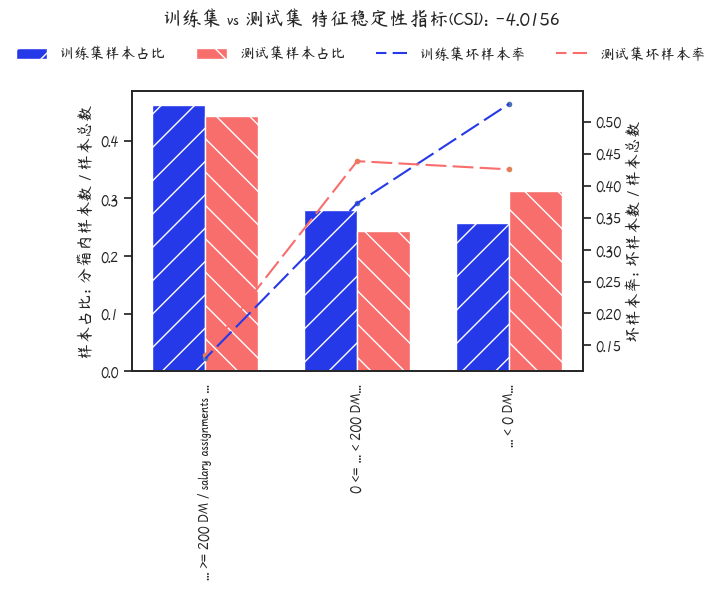

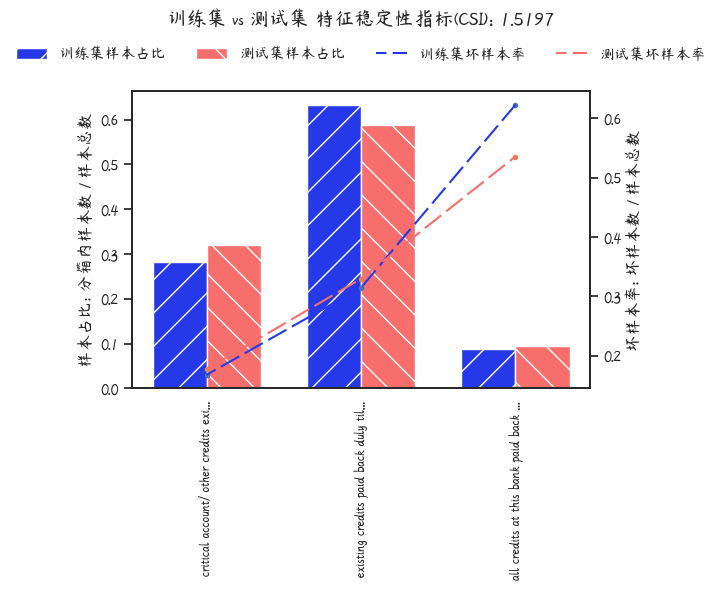

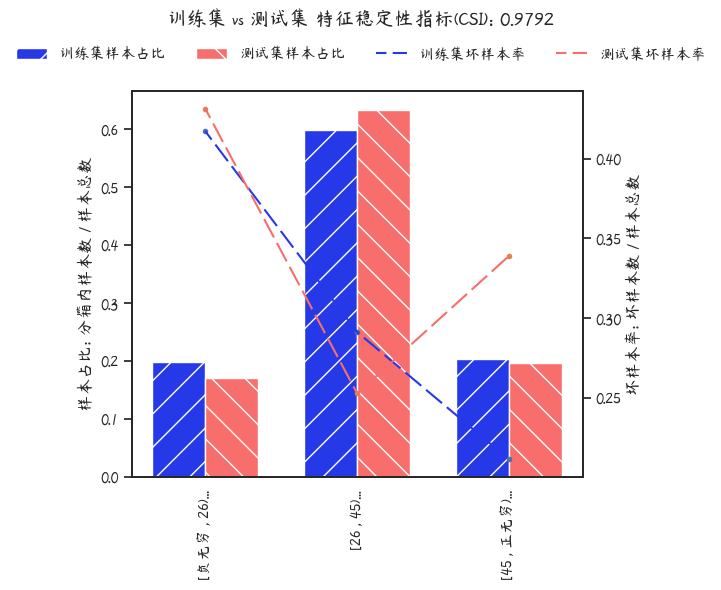

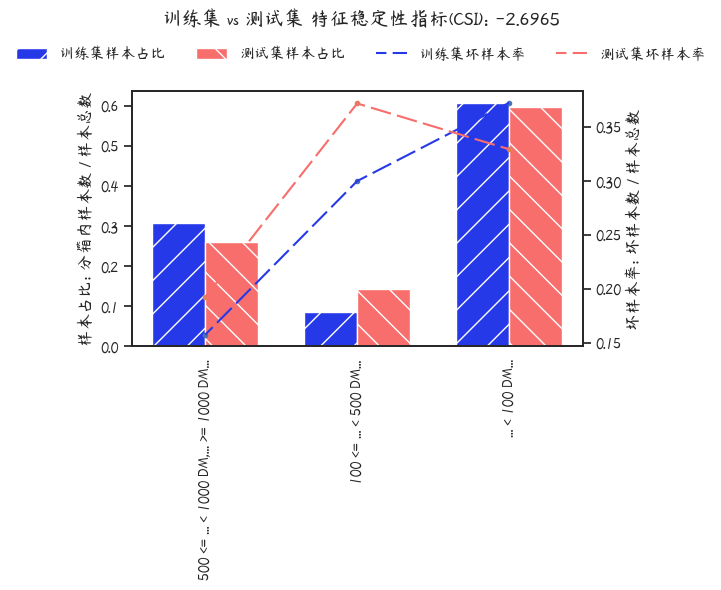

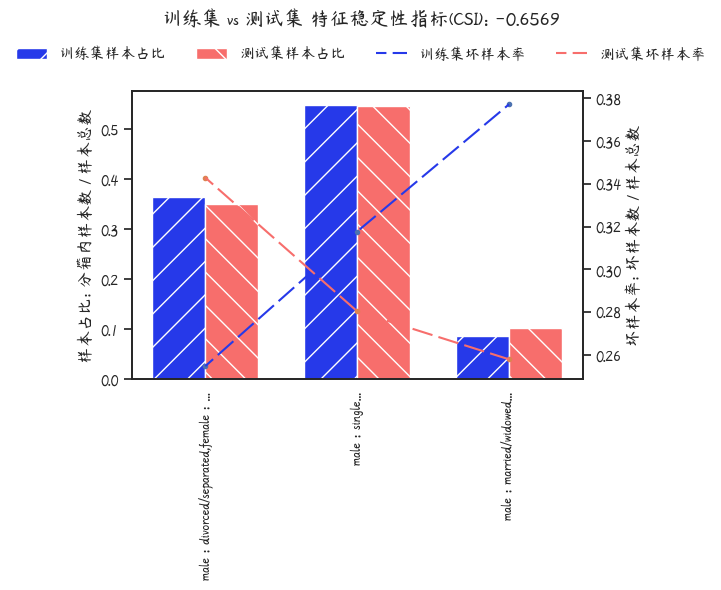

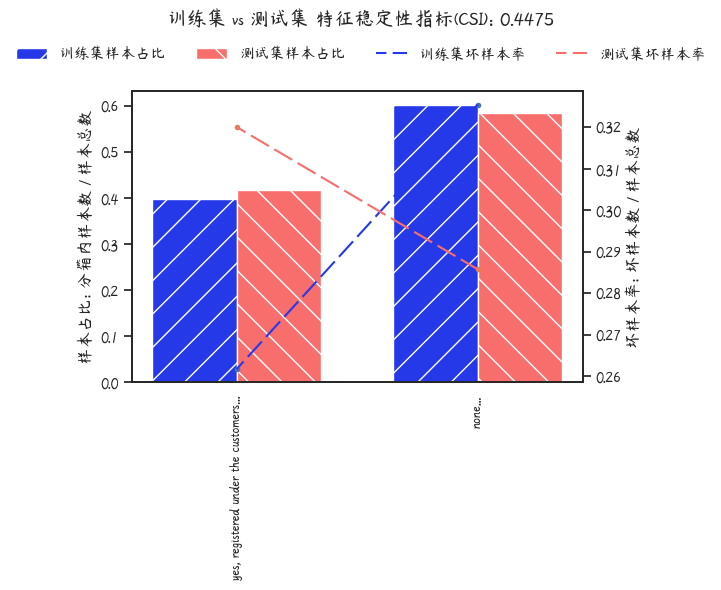

In [ ]:
for col in card._feature_names:
    feature_table_train = sp.feature_bin_stats(train, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=feature_pipeline.named_steps["combiner"])
    feature_table_test = sp.feature_bin_stats(test, col, target=target, desc=feature_map.get(col, "") or "逻辑回归入模变量", combiner=feature_pipeline.named_steps["combiner"])
    
    csi_table = sp.csi_plot(feature_table_train, feature_table_test, card[col], result=True, plot=True, max_len=35, figsize=(6, 6), labels=["训练集", "测试集"])

7.4 评分卡模型导出 pmml 文件

In [ ]:
card.scorecard2pmml?

Signature: card.scorecard2pmml(pmml: str = 'scorecard.pmml', debug: bool = False)
Docstring:
export a scorecard to pmml

Args:
    pmml (str): io to write pmml file.
    debug (bool): If true, print information about the conversion process.
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/model.py
Type:      method


In [ ]:
card.scorecard2pmml(pmml="scorecard.pmml", debug=True)

python: 3.8.13
sklearn: 1.2.2
sklearn2pmml: 0.92.2
joblib: 1.2.0
sklearn_pandas: 2.2.0
pandas: 1.5.3
numpy: 1.22.2
java: 1.8.0_221
Executing command:
java -cp /Users/lubberit/anaconda3/envs/score/lib/python3.8/site-packages/sklearn2pmml/resources/sklearn2pmml-1.0-SNAPSHOT.jar:/Users/lubberit/anaconda3/envs/score/lib/python3.8/site-packages/sklearn2pmml/resources/gson-2.10.jar:/Users/lubberit/anaconda3/envs/score/lib/python3.8/site-packages/sklearn2pmml/resources/guava-21.0.jar:/Users/lubberit/anaconda3/envs/score/lib/python3.8/site-packages/sklearn2pmml/resources/h2o-genmodel-3.40.0.4.jar:/Users/lubberit/anaconda3/envs/score/lib/python3.8/site-packages/sklearn2pmml/resources/h2o-logger-3.40.0.4.jar:/Users/lubberit/anaconda3/envs/score/lib/python3.8/site-packages/sklearn2pmml/resources/h2o-tree-api-0.3.17.jar:/Users/lubberit/anaconda3/envs/score/lib/python3.8/site-packages/sklearn2pmml/resources/istack-commons-runtime-4.0.1.jar:/Users/lubberit/anaconda3/envs/score/lib/python3.8/site-pac

8 模型报告输出

In [ ]:
sp.ExcelWriter?

Init signature:
sp.ExcelWriter(
    style_excel='/Users/lubberit/Desktop/workspace/scorecardpipeline/scorecardpipeline/template.xlsx',
    style_sheet_name='初始化',
    fontsize=10,
    font='楷体',
    theme_color='8E8BFE',
)
Docstring:      <no docstring>
Init docstring:
excel 文件内容写入公共方法

:param style_excel: 样式模版文件，默认当前路径下的 template.xlsx ，如果项目路径调整需要进行相应的调整
:param style_sheet_name: 模版文件内初始样式sheet名称，默认即可
:param fontsize: 插入excel文件中内容的字体大小，默认 10
:param font: 插入excel文件中内容的字体，默认 楷体
:param theme_color: 主题色，默认 8E8BFE，注意不包含 #
File:           ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/excel_writer.py
Type:           type
Subclasses:     


In [ ]:
sp.ExcelWriter.insert_value2sheet?

Signature:
sp.ExcelWriter.insert_value2sheet(
    self,
    worksheet,
    insert_space,
    value='',
    style='content',
    auto_width=False,
)
Docstring:
向sheet中的某个单元格插入某种样式的内容

:param worksheet: 需要插入内容的sheet
:param insert_space: 内容插入的单元格位置，可以是 "B2" 或者 (2, 2) 任意一种形式
:param value: 需要插入的内容
:param style: 渲染的样式，参考 init_style 中初始设置的样式
:param auto_width: 是否开启自动调整列宽
:return 返回插入元素最后一列之后、最后一行之后的位置
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/excel_writer.py
Type:      function


In [ ]:
sp.ExcelWriter.insert_pic2sheet?

Signature:
sp.ExcelWriter.insert_pic2sheet(
    self,
    worksheet,
    fig,
    insert_space,
    figsize=(600, 250),
)
Docstring:
向excel中插入图片内容

:param worksheet: 需要插入内容的sheet
:param fig: 需要插入的图片路径
:param insert_space: 插入图片的起始单元格
:param figsize: 图片大小设置
:return 返回插入元素最后一列之后、最后一行之后的位置
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/excel_writer.py
Type:      function


In [ ]:
sp.ExcelWriter.insert_df2sheet?

Signature:
sp.ExcelWriter.insert_df2sheet(
    self,
    worksheet,
    data,
    insert_space,
    merge_column=None,
    header=True,
    index=False,
    auto_width=False,
)
Docstring:
向excel文件中插入制定样式的dataframe数据

:param worksheet: 需要插入内容的sheet
:param data: 需要插入的dataframe
:param insert_space: 插入内容的起始单元格位置
:param merge_column: 需要分组显示的列，index或者列明
:param header: 是否存储dataframe的header，暂不支持多级表头
:param index: 是否存储dataframe的index
:param auto_width: 是否自动调整列宽
:return 返回插入元素最后一列之后、最后一行之后的位置
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/excel_writer.py
Type:      function


In [ ]:
sp.ExcelWriter.add_conditional_formatting?

Signature:
sp.ExcelWriter.add_conditional_formatting(
    self,
    worksheet,
    start_space,
    end_space,
)
Docstring:
设置条件格式

:param worksheet: 当前选择设置条件格式的sheet
:param start_space: 开始单元格位置
:param end_space: 结束单元格位置
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/excel_writer.py
Type:      function


In [ ]:
sp.ExcelWriter.set_number_format?

Signature: sp.ExcelWriter.set_number_format(worksheet, space, _format)
Docstring:
设置数值显示格式

:param worksheet: 当前选择调整数值显示格式的sheet
:param space: 单元格范围
:param _format: 显示格式，参考 openpyxl
File:      ~/Desktop/workspace/scorecardpipeline/scorecardpipeline/excel_writer.py
Type:      function


In [ ]:
# writer = ExcelWriter(style_excel="./utils/报告输出模版.xlsx", theme_color="8E8BFE")


# # ////////////////////////////////////// 样本说明 ///////////////////////////////////// #
# worksheet = writer.get_sheet_by_name("汇总信息")

# # 样本总体分布情况
# start_row, start_col = 2, 2
# end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="样本总体分布情况", style="header")
# end_row, end_col = writer.insert_df2sheet(worksheet, dataset_summary, (end_row + 1, start_col), header=True)

# writer.set_number_format(worksheet, f"{get_column_letter(end_col - 2)}{end_row - len(dataset_summary)}:{get_column_letter(end_col - 2)}{end_row}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(end_col - 4)}{end_row - len(dataset_summary)}:{get_column_letter(end_col - 4)}{end_row}", "0.00%")

# # 建模样本时间分布情况
# temp = sample_distribution(df, date="date", target="target", user_count="count", save="model_report/all_sample_time_count.png")
# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="建模样本时间分布情况", style="header")
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/all_sample_time_count.png", (end_row, start_col), figsize=(720, 370))
# end_row, end_col = writer.insert_df2sheet(worksheet, temp.T.reset_index(), (end_row, start_col), header=False)

# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 1}:{get_column_letter(end_col)}{end_row - 1}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 2}:{get_column_letter(end_col)}{end_row - 2}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 4}:{get_column_letter(end_col)}{end_row - 4}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 6}:{get_column_letter(end_col)}{end_row - 6}", "0.00%")

# # 训练集样本时间分布情况
# temp = sample_distribution(df, date="date", target="target", user_count="count", save="model_report/train_sample_time_count.png")
# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="训练集样本时间分布情况", style="header")
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_sample_time_count.png", (end_row, start_col), figsize=(720, 370))
# end_row, end_col = writer.insert_df2sheet(worksheet, temp.T.reset_index(), (end_row, start_col), header=False)

# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 1}:{get_column_letter(end_col)}{end_row - 1}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 2}:{get_column_letter(end_col)}{end_row - 2}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 4}:{get_column_letter(end_col)}{end_row - 4}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 6}:{get_column_letter(end_col)}{end_row - 6}", "0.00%")

# # 测试集样本时间分布情况
# temp = sample_distribution(df, date="date", target="target", user_count="count", save="model_report/test_sample_time_count.png")
# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="测试集样本时间分布情况", style="header")
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/test_sample_time_count.png", (end_row, start_col), figsize=(720, 370))
# end_row, end_col = writer.insert_df2sheet(worksheet, temp.T.reset_index(), (end_row, start_col), header=False)

# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 1}:{get_column_letter(end_col)}{end_row - 1}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 2}:{get_column_letter(end_col)}{end_row - 2}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 4}:{get_column_letter(end_col)}{end_row - 4}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 6}:{get_column_letter(end_col)}{end_row - 6}", "0.00%")

# # 跨时间验证集样本时间分布情况
# temp = sample_distribution(df, date="date", target="target", user_count="count", save="model_report/oot_sample_time_count.png")
# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="跨时间验证集样本时间分布情况", style="header")
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/oot_sample_time_count.png", (end_row, start_col), figsize=(720, 370))
# end_row, end_col = writer.insert_df2sheet(worksheet, temp.T.reset_index(), (end_row, start_col), header=False)

# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 1}:{get_column_letter(end_col)}{end_row - 1}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 2}:{get_column_letter(end_col)}{end_row - 2}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 4}:{get_column_letter(end_col)}{end_row - 4}", "0.00%")
# writer.set_number_format(worksheet, f"{get_column_letter(start_col)}{end_row - 6}:{get_column_letter(end_col)}{end_row - 6}", "0.00%")


# # ////////////////////////////////////// 模型报告 ///////////////////////////////////// #

# # 逻辑回归拟合情况
# worksheet = writer.get_sheet_by_name("逻辑回归拟合结果")

# start_row, start_col = 2, 2

# end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="逻辑回归拟合效果", style="header")
# # worksheet.merge_cells(f"{get_column_letter(start_col)}{start_row}:{get_column_letter(start_col + len(summary.columns) - 1)}{start_row}")
# # worksheet[f"{get_column_letter(start_col)}{start_row}:{get_column_letter(start_col + len(summary.columns) - 1)}{start_row}"].style = "header"
# logistic.plot_weights(save="model_report/logistic_train.png")
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/logistic_train.png", (end_row + 2, start_col))
# end_row, end_col = writer.insert_df2sheet(worksheet, summary, (end_row + 1, start_col))

# conditional_column = get_column_letter(start_col + summary.columns.get_loc("Coef."))
# writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(summary)}', f'{conditional_column}{end_row}')

# # worksheet.merge_cells(f"{get_column_letter(start_col)}{end_row + 2}:{get_column_letter(start_col + len(train_report.columns) - 1)}{end_row + 2}")
# # worksheet[f"{get_column_letter(start_col)}{end_row + 2}"].style = "header"
# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="训练数据集拟合报告", style="header")
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/lr_ksplot_train.png", (end_row, start_col), figsize=(480, 270))
# end_row, end_col = writer.insert_df2sheet(worksheet, train_report, (end_row + 1, start_col))

# # worksheet.merge_cells(f"{get_column_letter(start_col)}{end_row + 2}:{get_column_letter(start_col + len(test_report.columns) - 1)}{end_row + 2}")
# # worksheet[f"{get_column_letter(start_col)}{end_row + 2}"].style = "header"
# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="测试数据集拟合报告", style="header")
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/lr_ksplot_test.png", (end_row, start_col), figsize=(480, 270))
# end_row, end_col = writer.insert_df2sheet(worksheet, test_report, (end_row + 1, start_col))

# # worksheet.merge_cells(f"{get_column_letter(start_col)}{end_row + 2}:{get_column_letter(start_col + len(oot_report.columns) - 1)}{end_row + 2}")
# # worksheet[f"{get_column_letter(start_col)}{end_row + 2}"].style = "header"
# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="跨时间验证集拟合报告", style="header")
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/lr_ksplot_oot.png", (end_row, start_col), figsize=(480, 270))
# end_row, end_col = writer.insert_df2sheet(worksheet, oot_report, (end_row + 1, start_col))


# # ////////////////////////////////////// 特征概述 ///////////////////////////////////// #
# worksheet = writer.get_sheet_by_name("模型变量信息")

# start_row, start_col = 2, 2
# end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="入模变量信息", style="header")
# end_row, end_col = writer.insert_df2sheet(worksheet, feature_describe.reset_index().rename(columns={"index": "序号"}), (end_row + 1, start_col))

# # 变量分布情况
# data_info = toad.detect(data[card.rules.keys()]).reset_index().rename(columns={"index": "变量名称", "type": "变量类型", "size": "样本个数", "missing": "缺失值", "unique": "唯一值个数"})
# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="变量分布情况", style="header")
# end_row, end_col = writer.insert_df2sheet(worksheet, data_info, (end_row + 1, start_col))

# # 变量相关性
# data_corr = logistic.corr(feature_pipeline.transform(train), save="model_report/data_corr.png", annot=False)
# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="变量相关性", style="header")
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/data_corr.png", (end_row + 1, start_col), figsize=(700, 500))
# end_row, end_col = writer.insert_df2sheet(worksheet, data_corr.reset_index().rename(columns={"index": ""}), (end_row + 1, start_col))

# conditional_column = f"{get_column_letter(start_col + 1)}{end_row - len(data_corr)}:{get_column_letter(end_col - 1)}{end_row - 1}"
# worksheet.conditional_formatting.add(conditional_column, ColorScaleRule(start_type='num', start_value=-1.0, start_color='8E8BFE', mid_type='num', mid_value=0., mid_color='FFFFFF', end_type='num', end_value=1.0, end_color='8E8BFE'))


# # 变量分箱信息
# _combiner = feature_pipeline.named_steps["combiner"]

# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="变量分箱信息", style="header")
# for col in card.rules.keys():
#     feature_table = card.feature_bin_stats(data, col, target=target, desc="逻辑回归入模变量", combiner=card.combiner)
#     # _combiner.bin_plot(data, col, labels=True, save=f"model_report/bin_plots/data_{col}.png")
#     bin_plot(feature_table, feature=col, save=f"model_report/bin_plots/data_{col}.png")
#     end_row, end_col = writer.insert_pic2sheet(worksheet, f"model_report/bin_plots/data_{col}.png", (end_row + 1, start_col), figsize=(700, 400))
#     end_row, end_col = writer.insert_df2sheet(worksheet, feature_table, (end_row, start_col))

#     for c in ["坏样本率", "LIFT值"]:
#         conditional_column = get_column_letter(start_col + feature_table.columns.get_loc(c))
#         writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(feature_table)}', f'{conditional_column}{end_row}')
#         # conditional_column = get_column_letter(start_col + feature_table.columns.get_loc("LIFT值"))
#         # writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(feature_table)}', f'{conditional_column}{end_row}')

#     for c in ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值"]:
#         conditional_column = get_column_letter(start_col + feature_table.columns.get_loc(c))
#         writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(feature_table)}:{conditional_column}{end_row}", "0.00%")


# # ////////////////////////////////////// 评分卡说明 ///////////////////////////////////// #

# # 评分卡刻度
# scorecard_kedu = pd.DataFrame(
#     [
#         ["base_odds", card.base_odds, "根据业务经验设置的基础比率（违约概率/正常概率），估算方法：（1-样本坏客户占比）/坏客户占比"],
#         ["base_score", card.base_score, "基础ODDS对应的分数"],
#         ["rate", card.rate, "设置分数的倍率"],
#         ["pdo", card.pdo, "表示分数增长PDO时，ODDS值增长到RATE倍"],
#         ["B", card.offset, "补偿值，计算方式：pdo / ln(rate)"],
#         ["A", card.factor, "刻度，计算方式：base_score - B * ln(base_odds)"],
#     ],
#     columns=["刻度项", "刻度值", "备注"],
# )

# worksheet = writer.get_sheet_by_name("评分卡结果")
# start_row, start_col = 2, 2
# end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="评分卡刻度", style="header")
# end_row, end_col = writer.insert_df2sheet(worksheet, scorecard_kedu, (end_row + 1, start_col))

# # 评分卡对应分数
# card_points = card.export(to_frame=True).rename(columns={"name": "变量名称", "value": "变量分箱", "score": "对应分数"})
# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="评分卡分数", style="header")
# end_row, end_col = writer.insert_df2sheet(worksheet, card_points, (end_row + 1, start_col), merge_column="变量名称")

# # 评分效果
# clip = 50
# clip_start = max(math.ceil(train["score"].min() / clip) * clip, math.ceil(train["score"].quantile(0.01) / clip) * clip)
# clip_end = min(math.ceil(train["score"].max() / clip) * clip, math.ceil(train["score"].quantile(0.99) / clip) * clip)
# score_clip = [i for i in range(clip_start, clip_end, clip)]

# train_score_rank = card.feature_bin_stats(train, "score", target=target, rules=score_clip, verbose=0, method="step", ks=True)
# test_score_rank = card.feature_bin_stats(test, "score", target=target, rules=score_clip, verbose=0, method="step", ks=True)
# oot_score_rank = card.feature_bin_stats(oot, "score", target=target, rules=score_clip, verbose=0, method="step", ks=True)

# card.ks_plot(train["score"], train[target], title="Train Dataset", save="model_report/train_ksplot.png")
# card.ks_plot(test["score"], test[target], title="Test Dataset", save="model_report/test_ksplot.png")
# card.ks_plot(oot["score"], oot[target], title="OOT Dataset", save="model_report/oot_ksplot.png")

# card.score_hist(train["score"], train[target], save="model_report/train_scorehist.png", bins=30, figsize=(13, 10))
# card.score_hist(test["score"], test[target], save="model_report/test_scorehist.png", bins=30, figsize=(13, 10))
# card.score_hist(oot["score"], oot[target], save="model_report/oot_scorehist.png", bins=30, figsize=(13, 10))


# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="训练数据集评分模型效果", style="header")
# ks_row = end_row
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_ksplot.png", (ks_row, start_col))
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_scorehist.png", (ks_row, end_col))
# end_row, end_col = writer.insert_df2sheet(worksheet, train_score_rank, (end_row + 1, start_col))

# for c in ["坏样本率", "LIFT值", "分档KS值"]:
#     conditional_column = get_column_letter(start_col + train_score_rank.columns.get_loc(c))
#     writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(train_score_rank)}', f'{conditional_column}{end_row}')

# for c in ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "分档KS值"]:
#     conditional_column = get_column_letter(start_col + train_score_rank.columns.get_loc(c))
#     writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(train_score_rank)}:{conditional_column}{end_row}", "0.00%")

# # conditional_column = get_column_letter(start_col + train_score_rank.columns.get_loc("坏样本率"))
# # writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(train_score_rank)}', f'{conditional_column}{end_row}')
# # conditional_column = get_column_letter(start_col + train_score_rank.columns.get_loc("LIFT值"))
# # writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(train_score_rank)}', f'{conditional_column}{end_row}')
# # conditional_column = get_column_letter(start_col + train_score_rank.columns.get_loc("分档KS值"))
# # writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(train_score_rank)}', f'{conditional_column}{end_row}')


# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="测试数据集评分模型效果", style="header")
# ks_row = end_row
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/test_ksplot.png", (ks_row, start_col))
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/test_scorehist.png", (ks_row, end_col))
# end_row, end_col = writer.insert_df2sheet(worksheet, test_score_rank, (end_row + 1, start_col))

# for c in ["坏样本率", "LIFT值", "分档KS值"]:
#     conditional_column = get_column_letter(start_col + test_score_rank.columns.get_loc(c))
#     writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(test_score_rank)}', f'{conditional_column}{end_row}')

# for c in ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "分档KS值"]:
#     conditional_column = get_column_letter(start_col + test_score_rank.columns.get_loc(c))
#     writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(test_score_rank)}:{conditional_column}{end_row}", "0.00%")

# # conditional_column = get_column_letter(start_col + test_score_rank.columns.get_loc("坏样本率"))
# # writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(test_score_rank)}', f'{conditional_column}{end_row}')
# # conditional_column = get_column_letter(start_col + test_score_rank.columns.get_loc("LIFT值"))
# # writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(test_score_rank)}', f'{conditional_column}{end_row}')
# # conditional_column = get_column_letter(start_col + test_score_rank.columns.get_loc("分档KS值"))
# # writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(test_score_rank)}', f'{conditional_column}{end_row}')


# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="跨时间验证集评分模型效果", style="header")
# ks_row = end_row
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/oot_ksplot.png", (ks_row, start_col))
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/oot_scorehist.png", (ks_row, end_col))
# end_row, end_col = writer.insert_df2sheet(worksheet, oot_score_rank, (end_row + 1, start_col))

# for c in ["坏样本率", "LIFT值", "分档KS值"]:
#     conditional_column = get_column_letter(start_col + oot_score_rank.columns.get_loc(c))
#     writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row - len(oot_score_rank)}', f'{conditional_column}{end_row}')

# for c in ["样本占比", "好样本占比", "坏样本占比", "坏样本率", "LIFT值", "累积LIFT值", "分档KS值"]:
#     conditional_column = get_column_letter(start_col + oot_score_rank.columns.get_loc(c))
#     writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(oot_score_rank)}:{conditional_column}{end_row}", "0.00%")

# # conditional_column = get_column_letter(start_col + oot_score_rank.columns.get_loc("坏样本率"))
# # writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(oot_score_rank)}', f'{conditional_column}{end_row}')
# # conditional_column = get_column_letter(start_col + oot_score_rank.columns.get_loc("LIFT值"))
# # writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(oot_score_rank)}', f'{conditional_column}{end_row}')
# # conditional_column = get_column_letter(start_col + oot_score_rank.columns.get_loc("分档KS值"))
# # writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(oot_score_rank)}', f'{conditional_column}{end_row}')

# train_test_score_psi = score_psi(train_score_rank, test_score_rank, labels=["训练数据集", "测试数据集"], save="model_report/train_test_psiplot.png")
# train_oot_score_psi = score_psi(train_score_rank, oot_score_rank, labels=["训练数据集", "跨时间验证集"], save="model_report/train_oot_psiplot.png")
# test_oot_score_psi = score_psi(test_score_rank, oot_score_rank, labels=["测试数据集", "跨时间验证集"], save="model_report/test_oot_psiplot.png")


# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="评分卡模型稳定性评估: 训练数据集 vs 测试数据集", style="header")
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_test_psiplot.png", (end_row, start_col), figsize=(1000, 400))
# end_row, end_col = writer.insert_df2sheet(worksheet, train_test_score_psi, (end_row + 1, start_col))

# conditional_column = get_column_letter(start_col + train_test_score_psi.columns.get_loc("分档PSI值"))
# writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(train_test_score_psi)}', f'{conditional_column}{end_row}')

# for c in ["训练数据集样本占比", "训练数据集坏样本率", "测试数据集样本占比", "测试数据集坏样本率"]:
#     conditional_column = get_column_letter(start_col + train_test_score_psi.columns.get_loc(c))
#     writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(train_test_score_psi)}:{conditional_column}{end_row}", "0.00%")


# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="评分卡模型稳定性评估: 训练数据集 vs 跨时间验证集", style="header")
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/train_oot_psiplot.png", (end_row, start_col), figsize=(1000, 400))
# end_row, end_col = writer.insert_df2sheet(worksheet, train_oot_score_psi, (end_row + 1, start_col))

# conditional_column = get_column_letter(start_col + train_oot_score_psi.columns.get_loc("分档PSI值"))
# writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(train_oot_score_psi)}', f'{conditional_column}{end_row}')

# for c in ["训练数据集样本占比", "训练数据集坏样本率", "跨时间验证集样本占比", "跨时间验证集坏样本率"]:
#     conditional_column = get_column_letter(start_col + train_oot_score_psi.columns.get_loc(c))
#     writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(train_oot_score_psi)}:{conditional_column}{end_row}", "0.00%")


# end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="评分卡模型稳定性评估: 测试数据集 vs 跨时间验证集", style="header")
# end_row, end_col = writer.insert_pic2sheet(worksheet, "model_report/test_oot_psiplot.png", (end_row, start_col), figsize=(1000, 400))
# end_row, end_col = writer.insert_df2sheet(worksheet, test_oot_score_psi, (end_row + 1, start_col))

# conditional_column = get_column_letter(start_col + test_oot_score_psi.columns.get_loc("分档PSI值"))
# writer.add_conditional_formatting(worksheet, f'{conditional_column}{end_row-len(test_oot_score_psi)}', f'{conditional_column}{end_row}')

# for c in ["跨时间验证集样本占比", "跨时间验证集坏样本率", "测试数据集样本占比", "测试数据集坏样本率"]:
#     conditional_column = get_column_letter(start_col + test_oot_score_psi.columns.get_loc(c))
#     writer.set_number_format(worksheet, f"{conditional_column}{end_row - len(test_oot_score_psi)}:{conditional_column}{end_row}", "0.00%")


# # ////////////////////////////////////// 模型稳定性 ///////////////////////////////////// #
# #
# # worksheet = writer.get_sheet_by_name("模型稳定性")
# # start_row, start_col = 2, 2
# #
# # # 变量 CSI 表
# # end_row, end_col = writer.insert_value2sheet(worksheet, (start_row, start_col), value="入模变量稳定性指标 (Characteristic Stability Index, CSI)", style="header")
# #
# # # train vs test
# #
# # # 评分分布稳定性
# # end_row, end_col = writer.insert_value2sheet(worksheet, (end_row + 2, start_col), value="模型评分稳定性指标 (Population Stability Index, PSI)", style="header")


# writer.save("model_report/评分卡模型报告.xlsx")